In [138]:
import numpy as np
import matplotlib.pyplot as plt
import scipy.linalg
import scipy.special
import copy
import sklearn.datasets
import scipy.sparse as sparse
from scipy.sparse import csr_matrix, linalg
from scipy.io import loadmat
import time
import threading
import heapq

In [139]:
class Logistic1:
    def __init__(self, X, Y, reg):
        self.X = X
        self.Y = Y
        self.μ = reg
        self.d = X.shape[1]
        self.N = X.shape[0]        


    def f(self, w):
        pred = self.Y * (self.X @ w)
        pos = np.sum(np.log(1+np.exp(-pred[pred>=0])))
        neg = np.sum(np.log(1+np.exp(pred[pred<0]))-pred[pred<0])
        return pos/self.N + neg/self.N + 0.5 * self.μ * (w.T @ w)[0, 0]
    
    def grad(self, w):
        pred = self.Y * (self.X @ w)
        p = 0.5 * (1 + np.tanh(-0.5 * pred))
        return -self.X.T @ (self.Y * p)/self.N + self.μ * w

    
    def hes(self, w):
        pred = self.Y * (self.X @ w)
        p = 0.5 * (1 + np.tanh(-0.5 * pred))
        return self.X.T @ (self.X * p * (1-p))/self.N + self.μ * np.eye(self.d)

    def hesU(self, w, U):
            pred = self.Y * (self.X @ w)
            p = 0.5 * (1 + np.tanh(-0.5 * pred))
            return self.X.T@(self.X*p*(1-p)@U)/self.N+self.μ*U
    
    def hes_diag(self, w):
        pred = self.Y * (self.X @ w)
        p = 0.5 * (1 + np.tanh(-0.5 * pred))
        return np.sum(self.X ** 2 * p * (1-p), axis=0)/self.N + self.μ * np.ones(self.d)


In [64]:
def Block_BFGS_Gao(w, L, tau, epochs):
    d = oracle.d
    invG = 1/L * np.eye(d)
    gw = oracle.grad(w)
    res = [np.linalg.norm(gw)]
    U = np.zeros([d,tau])
    time_t = [0]
    ts = time.time()
    for i in range(epochs):
        wj = w.copy()
        for j in range(tau):
            gw = oracle.grad(wj)
            dw = -invG@gw
            U[:,j] = dw.copy().reshape(-1)
            wj = wj + dw
        w = wj
        res.append(np.linalg.norm(oracle.grad(w)))
        time_t.append(time.time()-ts)
        AU = oracle.hesU(w, U)
        V=np.linalg.inv(U.T@AU)
        tmp=(U@V)@((AU).T@invG)
        invG=invG-tmp.T-tmp+U@(V@U.T)+((tmp@AU)@V)@U.T

    return res, time_t

        
        

In [78]:
def Block_BFGS_Faster(w, Lip, M, tau, epochs, corr=1):
    d = oracle.d
    L = 1/Lip**0.5*np.eye(d)
    gw = oracle.grad(w)
    res = [np.linalg.norm(gw)]
    time_t = [0]
    ts = time.time()
    for i in range(epochs):
        dw = -L.T@(L@gw)
        if corr:
            r = np.sqrt(dw.T @ oracle.hesU(w, dw))
            L = L / (1 + M * r)**0.5
        w = w+dw        
        U = np.random.randn(d,tau)
        LU = L.T@U
        ALU = oracle.hesU(w, LU)
        ALUsqrt = scipy.linalg.sqrtm(np.linalg.inv(LU.T@ALU))
        L = L + (U@(scipy.linalg.sqrtm(np.linalg.inv(U.T@U))) - L@(ALU@ALUsqrt))@(ALUsqrt@LU.T)
        gw = oracle.grad(w)
        res.append(np.linalg.norm(gw))
        time_t.append(time.time()-ts)
        if i%10 == 0:
            print(res[-1])
    return res, time_t

In [19]:
def rasrk_sol(w, L, M, tau,epochs, corr=True):
    d=oracle.d
    invG=1/L*np.eye(d)
    gw = oracle.grad(w)
    res = [np.linalg.norm(gw)]
    time_t=[0]
    ts=time.time()
#    invG = np.linalg.pinv(G)
    for i in range(epochs):
        dw = - invG @ gw

        w = w + dw    
        gw = oracle.grad(w)

        # if np.linalg.norm(gw_)<np.linalg.norm(gw):
        #     w=w_
        #     gw=gw_
        #     corr= True
        # else:
        #     corr=False

        
        if corr:
            r = np.sqrt(dw.T @ oracle.hesU(w, dw))
           # G = G * (1 + M * r)
            invG = invG / (1 + M * r)
        U = np.random.randn(d, tau)
  #      GU = G @ U
        AU = oracle.hesU(w, U)
#        G = G - (Gu - Au) @ (Gu - Au).T / (u.T @ (Gu - Au) + 1e-30)
        V = invG @ AU
        Delta=U-V
        invG = invG + (Delta) @ ((np.linalg.inv(AU.T@(Delta)+1e-20*np.eye(tau)))@Delta.T )

        res.append(np.linalg.norm(gw))
        time_t.append(time.time()-ts)
        if i%10==0:
            print(res[-1])
    print(res[-1])
    return res,time_t

In [20]:
def Newton(w, epochs):
    res=[]
    x_obj=[]
    for i in range(epochs):
        dw= - np.linalg.inv(oracle.hes(w))@oracle.grad(w)
        w=w+dw
        res.append(np.linalg.norm(oracle.grad(w)))
        x_obj.append(w)
    return res,x_obj



In [21]:
def rasrk_practical_sol(w, L, M, tau,epochs, corr=True):
    d=oracle.d
    invG=1/L*np.eye(d)
    gw = oracle.grad(w)
    res = [np.linalg.norm(gw)]
    time_t=[0]
    ts=time.time()
#    invG = np.linalg.pinv(G)
    for i in range(epochs):
        dw = - invG @ gw

        w_ = w + dw    
        gw_ = oracle.grad(w_)

        if np.linalg.norm(gw_)<np.linalg.norm(gw):
            w=w_
            gw=gw_
            corr= True
        else:
            corr=False

        
        if corr:
            r = np.sqrt(dw.T @ oracle.hesU(w, dw))
           # G = G * (1 + M * r)
            invG = invG / (1 + M * r)
        U = np.random.randn(d, tau)
  #      GU = G @ U
        AU = oracle.hesU(w, U)
#        G = G - (Gu - Au) @ (Gu - Au).T / (u.T @ (Gu - Au) + 1e-30)
        V = invG @ AU
        Delta=U-V
        invG = invG + (Delta) @ ((np.linalg.inv(AU.T@(Delta)+1e-20*np.eye(tau)))@Delta.T )

        res.append(np.linalg.norm(gw))
        time_t.append(time.time()-ts)
        if i%10==0:
            print(res[-1])
    print(res[-1])
    return res,time_t

In [22]:
def grsr1_sol(w, L, M, epochs, corr=True):
    d=oracle.d
    G=L*np.eye(d)
    invG=1/L*np.eye(d)
    gw = oracle.grad(w)
  #  invG = np.linalg.pinv(G)
    res = [np.linalg.norm(gw)]
    time_t=[0]
    ts=time.time()
    for i in range(epochs):
        dw = - invG @ gw
        w_ = w + dw    
        gw_ = oracle.grad(w_)

        if np.linalg.norm(gw_)<np.linalg.norm(gw):
            gw = gw_
            w=w_
            corr=True
        else:
            corr = False
        
        if corr:
            r = np.sqrt(dw.T @ oracle.hesU(w, dw))
            G = G * (1 + M * r)
            invG = invG / (1 + M * r)
        
        ind = np.argmax(np.diag(G) - oracle.hes_diag(w))

        u = np.zeros([d, 1])
        u[ind] = 1
    
        Gu = G @ u
        Au = oracle.hesU(w, u)
        G = G - (Gu - Au) @ (Gu - Au).T / (u.T @ (Gu - Au) + 1e-30)
        
        v = invG @ Au
        invG = invG + (u - v) @ (u - v).T / (u.T @ oracle.hesU(w, u-v) + 1e-30) 
        gw = oracle.grad(w)
        res.append(np.linalg.norm(gw))
        time_t.append(time.time()-ts)
        if i%50 == 0:
            print(res[-1])
    print(res[-1])
    return res,time_t

In [23]:
def grsrk_sol(w,L,M, tau, epochs, corr=True):
    d=oracle.d
    G=L*np.eye(d)
    invG=1/L*np.eye(d)
    gw=oracle.grad(w)
    res=[np.linalg.norm(gw)]
    time_t=[0]
    ts=time.time()
    I=np.eye(d)
    for i in range(epochs):
        dw = -invG@gw
    #    w = w.copy()
        w_ = w+dw
        gw_ = oracle.grad(w_)
        if np.linalg.norm(gw_)<np.linalg.norm(gw):
            gw = gw_
            w=w_
            corr=True
        else:
            corr=False
        
        if corr:
            r = np.sqrt(dw.T @ oracle.hesU(w, dw))
            G = G * (1 + M * r)
            invG = invG / (1 + M * r)

        
           
        ind = heapq.nlargest(tau,range(oracle.d),list(np.diag(G)-oracle.hes_diag(w)).__getitem__)
        U = I[:,ind]
        GU=G@U
        AU=oracle.hesU(w,U)
        DU=GU-AU
        G = G- DU@np.linalg.inv(U.T@DU+1e-20*np.eye(tau))@DU.T

        V = invG @ AU
        Delta=U-V
        invG = invG + (Delta) @ ((np.linalg.inv(AU.T@(Delta)+1e-20*np.eye(tau)))@Delta.T )


        res.append(np.linalg.norm(gw))
        time_t.append(time.time()-ts)
        if i%10==0:
            print(res[-1])
    print(res[-1])
    return res,time_t
        

In [137]:
def BlockBFGS(w,L,M,tau,epochs,corr=True):
    d=oracle.d
    invG=1/L*np.eye(d)
    gw = oracle.grad(w)
    res = [np.linalg.norm(gw)]
    time_t=[0]
    ts=time.time()
    tau0 = tau
#    invG = np.linalg.pinv(G)
    for i in range(epochs):
        dw = - invG @ gw
        if corr:
            r = np.sqrt(dw.T @ oracle.hesU(w, dw))
           # G = G * (1 + M * r)
            invG = invG / (1 + M * r)
  #      w1 = w.copy()
        w = w + dw   

        gw = oracle.grad(w)
    
        # if np.linalg.norm(gw1)<np.linalg.norm(gw):
        #     gw = gw1
        #     corr= False
        # else:
        #     w = w1
        #     tau = min(1,int(tau/2))  
        #     corr = True     
        
        U = np.random.randn(d, tau)
  #      GU = G @ U
        AU = oracle.hesU(w, U)
        V=np.linalg.inv(U.T@AU)
        tmp=(U@V)@((AU).T@invG)
        invG=invG-tmp.T-tmp+U@(V@U.T)+tmp@(AU@V@U.T)

        res.append(np.linalg.norm(gw))
        time_t.append(time.time()-ts)
        if i%10 ==0:
            print(res[-1])
    print(res[-1])
    return res,time_t
    

In [11]:
def BlockBFGSv1(w,L,tau,epochs):
    d=oracle.d
    invG=1/L*np.eye(d)
    gw = oracle.grad(w)
    res = [np.linalg.norm(gw)]
    time_t=[0]
    ts=time.time()
#    invG = np.linalg.pinv(G)
    for i in range(epochs):
        dw = - invG @ gw
        w1 = w.copy()
        w_ = w + dw       
    
        if oracle.f(w_)<oracle.f(w):
            gw = oracle.grad(w_)
            w = w_
        else:
            w = w1
        
        U = np.random.randn(d, tau)
  #      GU = G @ U
        AU = oracle.hesU(w1, U)
        V=np.linalg.inv(U.T@AU)
        tmp=(U@V)@((AU).T@invG)
        invG=invG-tmp.T-tmp+U@(V@U.T)+tmp@(AU@V@U.T)

        res.append(np.linalg.norm(gw))
        time_t.append(time.time()-ts)

        if i%10 ==0:
            print(res[-1])
    print(res[-1])
    return res,time_t

In [106]:
def BlockDFPv1(w,L,M,tau,epochs,corr=True):
    d=oracle.d
   # G=L*np.eye(d)
    invG=1/L*np.eye(d)
    gw = oracle.grad(w)
    res = [np.linalg.norm(gw)]
    time_t=[0]
    ts=time.time()
    I=np.eye(d)
#    invG = np.linalg.pinv(G)
    for i in range(epochs):
        dw = - invG @ gw

        
        if corr:
            r = np.sqrt(dw.T @ oracle.hesU(w, dw))
           # G = G * (1 + M * r)
            invG = invG / (1 + M * r)

        w = w+dw
        gw=oracle.grad(w)
        U = np.random.randn(d, tau)
        HU = oracle.hesU(w, U)
    #    InvU=invG@U
        PU=invG@HU
     #   invU =np.linalg.inv(U.T@HU)
     #   G= HU@(invU)@HU.T + (I-HU@invU@U.T)@G@(I-U@invU@HU.T)

        invG=invG+U@(np.linalg.inv(U.T@HU)@(U.T))-PU@(np.linalg.inv(HU.T@PU)@PU.T)

        res.append(np.linalg.norm(gw))
        time_t.append(time.time()-ts)
        if i%10 ==0:
            print(res[-1])
    return res,time_t

In [148]:
def BlockDFP(w,L,M,tau,epochs,corr=True):
    d=oracle.d
    G=L*np.eye(d)
    invG=1/L*np.eye(d)
    gw = oracle.grad(w)
    res = [np.linalg.norm(gw)]
    time_t=[0]
    ts=time.time()
    I=np.eye(d)
#    invG = np.linalg.pinv(G)
    for i in range(epochs):
        dw = - invG @ gw

        
        if corr:
            r = np.sqrt(dw.T @ oracle.hesU(w, dw))
            G = G * (1 + M * r)
         #   invG = invG / (1 + M * r)

        w = w+dw
        gw=oracle.grad(w)
        U = np.random.randn(d, tau)
        HU = oracle.hesU(w, U)
        invU =np.linalg.inv(U.T@HU)
        G= HU@(invU)@HU.T + (I-HU@invU@U.T)@G@(I-U@invU@HU.T)
        invG=np.linalg.inv(G)
        res.append(np.linalg.norm(gw))
        time_t.append(time.time()-ts)
        if i%10 ==0:
            print(res[-1])
    return res,time_t

In [13]:
def GD(w,L,epochs):
    gw = oracle.grad(w)
    res = [np.linalg.norm(gw)]
    time_t=[0]
    ts=time.time()
    for i in range(epochs):
        w=w-1/L*gw
        gw=oracle.grad(w)
        res.append(np.linalg.norm(gw))
        time_t.append(time.time()-ts)
    return res, time_t


## SVHN

In [327]:
m = loadmat('SVHN.mat')
A0=m['Z']
index_0=np.where(m['y']==1)[0]
index_1=np.where(m['y']==2)[0]
A_0=A0[index_0,:]
A_1=A0[index_1,:]
A=np.vstack((A_0,A_1))
A=A.astype("float")
n_0= A_0.shape[0]
b_0= -1*np.ones([n_0,1])
b_1 = 1*np.ones([A_1.shape[0],1])
b=np.vstack((b_0,b_1))


In [329]:
oracle=Logistic1(A,b,0.1/N)

In [330]:
x0=np.zeros([oracle.d,1])

In [333]:
res, x1=Newton(x0, 5)

In [334]:
res

[51.741273510619635,
 6.3481649319053135,
 0.3002624215905507,
 0.0012805336105131842,
 1.919987545827633e-07]

In [335]:
K_LIST=[1, 80, 200, 500, 1000]
grres_k=[]
grtime_k=[]
for k in K_LIST:
    print("k=",k)
    res_l, time_l=grsrk_sol(x1[4].copy(), 10000, 10, k ,50,True)
    grres_k.append(res_l)
    grtime_k.append(time_l)

k= 1
1.919987545827633e-07
1.919987545827633e-07
1.919987545827633e-07
1.919987545827633e-07
1.919987545827633e-07
1.919987545827633e-07
k= 80
1.919987545827633e-07
1.919987545827633e-07


KeyboardInterrupt: 

In [336]:
res_l, time_l=grsrk_sol(x1[4].copy(), 10000, 10000, k ,50,True)

1.919987545827633e-07
1.919987545827633e-07
6.491106490130985e-08
6.491106490130985e-08
6.491106490130985e-08
6.491106490130985e-08


In [337]:
res_l, time_l=grsrk_sol(x1[4].copy(), 10000, 10000, 200 ,50,True)

1.919987545827633e-07
1.9066654206903613e-08
8.654959086452192e-09
8.654959086452192e-09
8.654959086452192e-09
8.654959086452192e-09


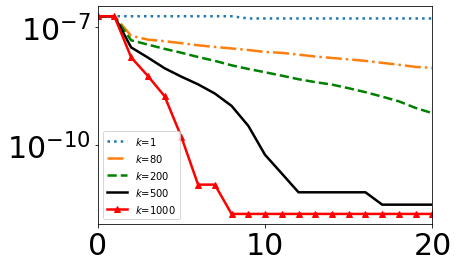

In [43]:
plt.plot(res_k[0],':', linewidth=2.5,label='$k$=1')
plt.plot(res_k[1],'-.', linewidth=2.5,label="$k$=80")
plt.plot(res_k[2],'--g',linewidth=2.5,label="$k$=200")
plt.plot(res_k[3],'-k',linewidth=2.5,label="$k$=500")
plt.plot(res_k[4],'-^r',linewidth=2.5,label="$k$=1000")
plt.tick_params(labelsize=30)
plt.xlim(0,20)
plt.legend()
plt.yscale("log")

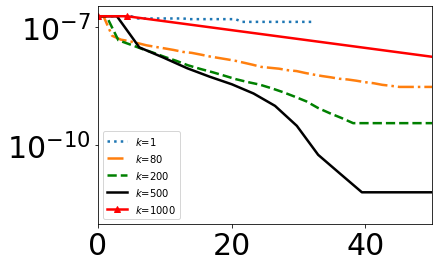

In [44]:
plt.plot(time_k[0],res_k[0],':', linewidth=2.5,label='$k$=1')
plt.plot(time_k[1],res_k[1],'-.', linewidth=2.5,label="$k$=80")
plt.plot(time_k[2],res_k[2],'--g',linewidth=2.5,label="$k$=200")
plt.plot(time_k[3], res_k[3],'-k',linewidth=2.5,label="$k$=500")
plt.plot(time_k[4], res_k[4],'-^r',linewidth=2.5,label="$k$=1000")
plt.tick_params(labelsize=30)
plt.legend()
plt.xlim(0,50)
plt.yscale("log")

In [45]:
for i in range(5):
    file_name_res= "data/"+"svhn_ra_res_"+str(K_LIST[i])+".npy"
    file_name_time="data/"+"svhn_ra_time_"+str(K_LIST[i])+".npy"
    np.save(file_name_res,res_k[i])
    np.save(file_name_time,time_k[i])

## Gisette

In [140]:
import pandas as pd


In [141]:
data=pd.read_csv('gisette.csv',header=1)

In [142]:
b0=data.values[:,0]
A0=data.values[:,1:]

In [143]:
A0=A0.astype("float")

In [144]:
N=A0.shape[0]
b0=b0.reshape(N,1).astype("float")

In [145]:
oracle=Logistic1(A0,b0,0.1/N)

In [146]:
x0=np.zeros([oracle.d,1])

In [147]:
res, x_list=Newton(x0, 20)

In [149]:
x1=x_list[12]

In [799]:
K_LIST=[1, 80, 200, 500, 1000]
grres_k=[]
grtime_k=[]
Rounds=[150,100,60,60,50]
i=0
for k in K_LIST:
    res_l, time_l=grsrk_sol(x1.copy(), 100, 100, k,Rounds[i],True)
    grres_k.append(res_l)
    grtime_k.append(time_l)
    i+=1

6.056281310028943e-07
5.949482976807545e-07
5.851520677849874e-07
5.761756771340639e-07
5.679585680371944e-07
5.313723306796094e-07
5.296177452011341e-07
5.200366658758089e-07
5.01868949246236e-07
5.01868949246236e-07
5.01868949246236e-07
4.975666610294162e-07
4.946261359552378e-07
4.933672507073256e-07
4.607289365640643e-07
4.549495925500672e-07
6.056281310028943e-07
1.9889949223942125e-07
1.3171095327845718e-07
6.771404433704416e-08
3.368946064321228e-08
1.3132367354669845e-08
6.0543342832877155e-09
1.390363326301099e-09
6.353717926078435e-11
9.60604314607922e-13
6.2219808287384915e-15
6.056281310028943e-07
9.230570772692393e-08
1.4340151187697412e-08
8.644572430605998e-10
1.948082670619822e-12
5.5573585496521e-17
5.5573585496521e-17
6.056281310028943e-07
1.003639409934897e-08
1.1487591907754013e-16
1.1487591907754013e-16
1.1487591907754013e-16
4.6291260722080185e-17
8.109214127643083e-18
6.056281310028943e-07
2.0954706938711588e-14
2.1664714843504275e-17
2.1664714843504275e-17
2.166

In [805]:
grres_k[3], grtime_k[3]=grsrk_sol(x1.copy(), 100, 100, 600,50,True)

6.056281310028943e-07
2.7747706234390673e-09
3.028257270609114e-17
3.028257270609114e-17
3.028257270609114e-17
3.028257270609114e-17


In [806]:
grres_k[4], grtime_k[4]=grsrk_sol(x1.copy(), 100, 100, 1000,20,True)

6.056281310028943e-07
2.0954706938711588e-14
2.1664714843504275e-17


In [212]:
grres_k=[]
grtime_k=[]
K_LIST=[1, 80, 200, 500, 1000]
for i in range(len(K_LIST)):
    file_name_res= "data/"+"gisette_gr_res_"+str(K_LIST[i])+".npy"
    file_name_time="data/"+"gisette_gr_time_"+str(K_LIST[i])+".npy"
    grres_k.append(np.load(file_name_res))
    grtime_k.append(np.load(file_name_time))

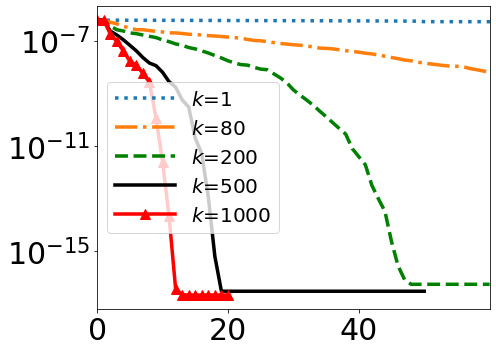

In [215]:
plt.rcParams['figure.figsize'] = (7, 5) #graph-size
params = {'legend.fontsize': 20,
          'legend.handlelength': 3} #legend-size
plt.rcParams.update(params)
plt.plot(grres_k[0],':', linewidth=3.5,label='$k$=1')
plt.plot(grres_k[1],'-.', linewidth=3.5,label="$k$=80")
plt.plot(grres_k[2],'--g',linewidth=3.5,label="$k$=200")
plt.plot(grres_k[3],'-k',linewidth=3.5,label="$k$=500")
plt.plot(grres_k[4],'-^r',linewidth=3.5,ms=10,label="$k$=1000")
plt.tick_params(labelsize=30)
plt.legend()
plt.yscale("log")

plt.yticks([1e-15,1e-11,1e-7])
#plt.ylim(1e-17,1e-4)
plt.xticks([0,20,40])
plt.xlim([0,60])
plt.tight_layout()
plt.savefig('graph_gr/gisette.res.png')
plt.savefig('graph_gr/gisette.res.pdf',format='pdf')

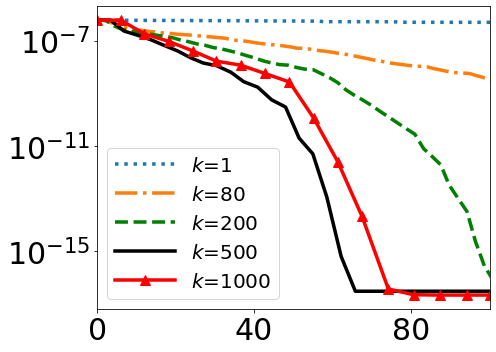

In [216]:
plt.rcParams['figure.figsize'] = (7, 5) #graph-size
params = {'legend.fontsize': 20,
          'legend.handlelength': 3} #legend-size
plt.rcParams.update(params)
plt.plot(grtime_k[0],grres_k[0],':', linewidth=3.5,label='$k$=1')
plt.plot(grtime_k[1],grres_k[1],'-.', linewidth=3.5,label="$k$=80")
plt.plot(grtime_k[2],grres_k[2],'--g',linewidth=3.5,label="$k$=200")
plt.plot(grtime_k[3], grres_k[3],'-k',linewidth=3.5,label="$k$=500")
plt.plot(grtime_k[4], grres_k[4],'-^r',ms=10,linewidth=3.5,label="$k$=1000")
plt.tick_params(labelsize=30)
plt.legend()
plt.yscale("log")


plt.yticks([1e-15,1e-11,1e-7])
plt.xticks([0,40,80])
plt.xlim(0,100)

plt.tight_layout()
plt.savefig('graph_gr/Gisette.time.png')
plt.savefig('graph_gr/Gisette.time.pdf',format='pdf')

In [217]:
res_k=[]
time_k=[]
K_LIST=[1, 80, 200, 500, 1000]
for i in range(len(K_LIST)):
    file_name_res= "data/"+"gisette_ra_res_"+str(K_LIST[i])+".npy"
    file_name_time="data/"+"gisette_ra_time_"+str(K_LIST[i])+".npy"
    res_k.append(np.load(file_name_res))
    time_k.append(np.load(file_name_time))

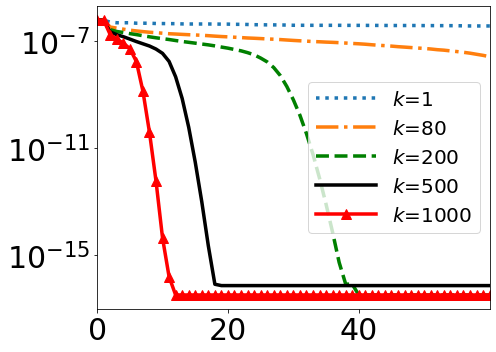

In [218]:
plt.rcParams['figure.figsize'] = (7, 5) #graph-size
params = {'legend.fontsize': 20,
          'legend.handlelength': 3} #legend-size
plt.rcParams.update(params)
plt.plot(res_k[0],':', linewidth=3.5,label='$k$=1')
plt.plot(res_k[1],'-.', linewidth=3.5,label="$k$=80")
plt.plot(res_k[2],'--g',linewidth=3.5,label="$k$=200")
plt.plot(res_k[3],'-k',linewidth=3.5,label="$k$=500")
plt.plot(res_k[4],'-^r',linewidth=3.5,ms=10,label="$k$=1000")
plt.tick_params(labelsize=30)
plt.legend()
plt.yscale("log")

plt.yticks([1e-15,1e-11,1e-7])
plt.xticks([0,20,40])
plt.xlim([0,60])
plt.tight_layout()
plt.savefig('new_graph/gisette.res.png')
plt.savefig('new_graph/gisette.res.pdf',format='pdf')

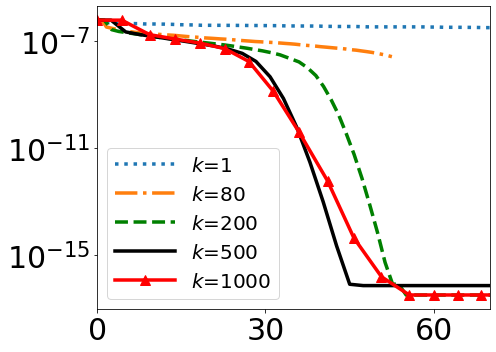

In [219]:
plt.rcParams['figure.figsize'] = (7, 5) #graph-size
params = {'legend.fontsize': 20,
          'legend.handlelength': 3} #legend-size
plt.rcParams.update(params)
plt.plot(time_k[0],res_k[0],':', linewidth=3.5,label='$k$=1')
plt.plot(time_k[1],res_k[1],'-.', linewidth=3.5,label="$k$=80")
plt.plot(time_k[2],res_k[2],'--g',linewidth=3.5,label="$k$=200")
plt.plot(time_k[3], res_k[3],'-k',linewidth=3.5,label="$k$=500")
plt.plot(time_k[4], res_k[4],'-^r',linewidth=3.5,ms=10, label="$k$=1000")
plt.tick_params(labelsize=30)
plt.legend()
plt.yscale("log")

plt.yticks([1e-15,1e-11,1e-7])
plt.xticks([0,30,60])
plt.xlim(0,70)

plt.tight_layout()
plt.savefig('new_graph/gisette.time.png')
plt.savefig('new_graph/gisette.time.pdf',format='pdf')

In [150]:
blockDFP, time_blockDFP=BlockDFP(x1.copy(),10000,100,200,60,True)

6.067360528952455e-07
1.607212318038636e-07
1.1722692375530038e-07
9.736924426063433e-08
8.02249255396199e-08
6.837599853180288e-08


In [ ]:
np.save("data/gisette_dfp_res_200.npy",blockDFP)

In [221]:
blockbfgsv1=np.load("data/gisette_bfgsv1_res_200.npy")
blockbfgs=np.load("data/gisette_bfgsv2_res_200.npy")
time_blockbfgsv1=np.load("data/gisette_bfgsv1_time_200.npy")
time_blockbfgs=np.load("data/gisette_bfgsv2_time_200.npy")

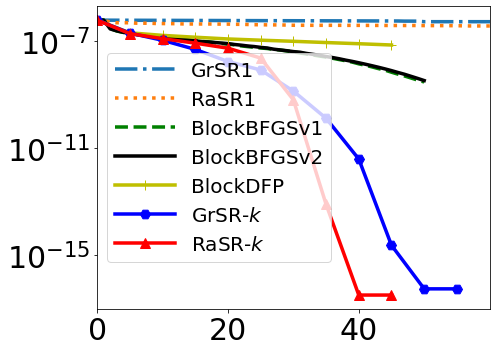

In [223]:
plt.rcParams['figure.figsize'] = (7, 5) #graph-size
params = {'legend.fontsize': 20,
          'legend.handlelength': 3} #legend-size
plt.rcParams.update(params)
res_gr1=grres_k[0]
res_grk=grres_k[2]
res_ra1=res_k[0]
res_rak=res_k[2]
plt.plot(res_gr1[:80],'-.',linewidth=3.5,label="GrSR1")
plt.plot(res_ra1[:80],':',linewidth=3.5,label="RaSR1")
plt.plot(blockbfgsv1[:80],'--g',linewidth=3.5,label="BlockBFGSv1")
plt.plot(blockbfgs[:80],'-k',linewidth=3.5, label="BlockBFGSv2")
plt.plot(np.arange(0, 50, 5), blockDFP[:50:5],'-+y',linewidth=3.5,ms=10,label="BlockDFP")
plt.plot(np.arange(0, 60, 5), res_grk[:60:5],'-Hb',linewidth=3.5,ms=10,label="GrSR-$k$")
plt.plot(np.arange(0, 50, 5), res_rak[:50:5],'-^r',linewidth=3.5,ms=10,label="RaSR-$k$")


plt.tick_params(labelsize=30) #axis-size
plt.legend(loc="center left") #legend-loc
plt.yscale("log")

plt.yticks([1e-15,1e-11,1e-7])
plt.xticks([0,20,40])
plt.xlim(0,60)
plt.tight_layout()
plt.savefig('Graph/gisette.res.png')
plt.savefig('Graph/gisette.res.pdf',format='pdf')

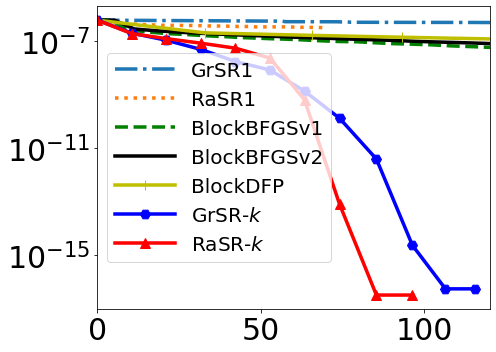

In [228]:
plt.rcParams['figure.figsize'] = (7, 5) #graph-size
params = {'legend.fontsize': 20,
          'legend.handlelength': 3} #legend-size
plt.rcParams.update(params)
res_gr1=grres_k[0]
time_gr1=grtime_k[0]
res_grk=grres_k[2]
time_grk=grtime_k[2]
res_ra1=res_k[0]
time_ra1=time_k[0]
res_rak=res_k[2]
time_rak=time_k[2]
plt.plot(time_gr1[:160],res_gr1[:160],'-.',linewidth=3.5,label="GrSR1")
plt.plot(time_ra1[:200],res_ra1[:200],':',linewidth=3.5,label="RaSR1")
plt.plot(time_blockbfgsv1[:80],blockbfgsv1[:80],'--g',linewidth=3.5,label="BlockBFGSv1")
plt.plot(time_blockbfgs[:80],blockbfgs[:80],'-k',linewidth=3.5, label="BlockBFGSv2")
plt.plot(time_blockbfgs[:50:5], blockDFP[:50:5],'-+y',linewidth=3.5,ms=10,label="BlockDFP")
plt.plot(time_grk[:60:5], res_grk[:60:5],'-Hb',ms=10,linewidth=3.5,label="GrSR-$k$")
plt.plot(time_grk[:50:5], res_rak[:50:5],'-^r',ms=10,linewidth=3.5,label="RaSR-$k$")


plt.tick_params(labelsize=30) #axis-size
plt.legend(loc="center left") #legend-loc
plt.yscale("log")

plt.yticks([1e-15,1e-11,1e-7])
plt.xticks([0,50,100])
plt.xlim(0,120)
plt.tight_layout()
plt.savefig('Graph/gisette.time.png')
plt.savefig('Graph/gisette.time.pdf',format='pdf')

## Data Store

In [824]:
for i in range(5):
    file_name_res= "data/"+"gisette_ra_res_"+str(K_LIST[i])+".npy"
    file_name_time="data/"+"gisette_ra_time_"+str(K_LIST[i])+".npy"
    np.save(file_name_res,res_k[i])
    np.save(file_name_time,time_k[i])

for i in range(5):
    file_name_res= "data/"+"gisette_gr_res_"+str(K_LIST[i])+".npy"
    file_name_time="data/"+"gisette_gr_time_"+str(K_LIST[i])+".npy"
    np.save(file_name_res,grres_k[i])
    np.save(file_name_time,grtime_k[i])

file_name_res= "data/"+"gisette_bfgsv1_res_200"+".npy"
file_name_time="data/"+"gisette_bfgsv1_time_200"+".npy"
np.save(file_name_res,blockbfgsv1)
np.save(file_name_time,time_blockbfgsv1)

file_name_res= "data/"+"gisette_bfgsv2_res_200"+".npy"
file_name_time="data/"+"gisette_bfgsv2_time_200"+".npy"
np.save(file_name_res,blockbfgs)
np.save(file_name_time,time_blockbfgs)

## CIFAR 10

## MNIST

In [308]:
m = loadmat('mnist.mat')
A0=m['Z']
index_0=np.where(m['y']==0)[0]
index_1=np.where(m['y']==1)[0]
A_0=A0[index_0,:]
A_1=A0[index_1,:]
A=np.vstack((A_0,A_1))
A=A.astype("float")
n_0= A_0.shape[0]
b_0= -1*np.ones([n_0,1])
b_1 = 1*np.ones([A_1.shape[0],1])
b=np.vstack((b_0,b_1))


In [309]:
N=A.shape[0]

In [310]:
oracle=Logistic1(A,b,0.1/N)

In [311]:
x0=np.zeros([oracle.d,1])

In [312]:
res, x1=Newton(x0, 19)

In [ ]:
K_LIST=[1, 80, 200, 500, 1000]
res_k=[]
time_k=[]
for k in K_LIST:
    res_l, time_l=rasrk_practical_sol(x1[-1].copy(), 10000, 10000, k ,50,True)
    res_k.append(res_l)
    time_k.append(time_l)

5.913943667197933e-06
3.897140931924658e-06
2.742141177611114e-06
2.699425293517578e-06
2.2806525195788063e-06
2.031403913382317e-06
5.913943667197933e-06
4.4160652263301475e-07
1.7367661039861203e-07
3.963661044055449e-08
6.024797457608759e-10
9.696874955086725e-17
5.913943667197933e-06
8.210985840804888e-08
8.251950048002921e-14
5.3168337620437465e-17
5.3168337620437465e-17
4.7433678546680807e-17
5.913943667197933e-06
1.305837565311764e-16
4.088157464379946e-17
4.088157464379946e-17
4.088157464379946e-17
4.088157464379946e-17
5.913943667197933e-06
5.913943667197933e-06
5.913943667197933e-06
5.913943667197933e-06
5.913943667197933e-06
5.913943667197933e-06


In [ ]:
res_k[2], time_k[2]=rasrk_practical_sol(x1[-1].copy(), 1000, 1000, 200 ,50,True)

5.913866440719493e-06
2.1426830830879545e-08
4.078568635940843e-17
4.078568635940843e-17
4.078568635940843e-17
4.078568635940843e-17


In [ ]:
res_k[3], time_k[3]=rasrk_practical_sol(x1[-1].copy(), 1000, 1000, 500 ,50,True)

5.913866440719493e-06
3.688171286356986e-17
3.557505699326585e-17
3.557505699326585e-17
3.557505699326585e-17
3.557505699326585e-17


In [ ]:
res_l, time_l=rasrk_practical_sol(x1[-1].copy(), 10000, 10000, 1 ,200,True)
res_k[0]=res_l
time_k[0]=time_l

5.913943667197933e-06
3.7420695160195627e-06
2.83868435058183e-06
2.4890965120716345e-06
2.4890965120716345e-06
2.336168451886529e-06
2.012527407880712e-06
1.9481067633410228e-06
1.650576516417748e-06
1.403727842249912e-06
1.2379261101610761e-06
1.160709968112546e-06
1.11945126594348e-06
1.0457260809824923e-06
1.0297988067350569e-06
1.0297988067350569e-06
1.0194411987084635e-06
9.466635633188062e-07
9.466635633188062e-07
9.466635633188062e-07
9.466635633188062e-07


In [287]:
res_k=[]
time_k=[]
K_LIST=[0, 80, 200, 500]
for i in range(len(K_LIST)):
    file_name_res= "data/"+"MNIST_ra_res_"+str(K_LIST[i])+".npy"
    file_name_time="data/"+"MNIST_ra_time_"+str(K_LIST[i])+".npy"
    res_k.append(np.load(file_name_res))
    time_k.append(np.load(file_name_time))

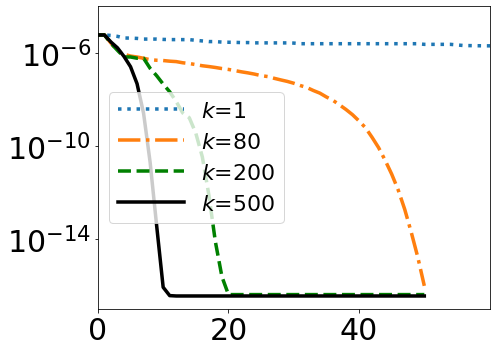

In [116]:
plt.rcParams['figure.figsize'] = (7, 5) #graph-size
params = {'legend.fontsize': 22,
          'legend.handlelength': 3} #legend-size
plt.rcParams.update(params)
plt.plot(res_k[0],':', linewidth=3.5,label='$k$=1')
plt.plot(res_k[1],'-.', linewidth=3.5,label="$k$=80")
plt.plot(res_k[2],'--g',linewidth=3.5,label="$k$=200")
plt.plot(res_k[3],'-k',linewidth=3.5,label="$k$=500")
#res_1000=res_k[4]
#plt.plot(np.arange(0,50, 5),res_1000[:50:5],'-^r',linewidth=2.5,label="$k$=1000")
plt.tick_params(labelsize=30)
plt.legend()
plt.yscale("log")

plt.yticks([1e-14,1e-10,1e-6])
plt.ylim(1e-17,1e-4)
plt.xticks([0,20,40])
plt.xlim([0,60])
plt.tight_layout()
plt.savefig('new_graph/MNIST.res.png')
plt.savefig('new_graph/MNIST.res.pdf',format='pdf')

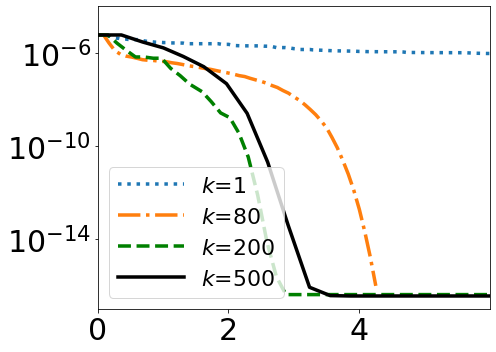

In [117]:
plt.rcParams['figure.figsize'] = (7, 5) #graph-size
params = {'legend.fontsize': 22,
          'legend.handlelength': 3} #legend-size
plt.rcParams.update(params)
plt.plot(time_k[0],res_k[0],':', linewidth=3.5,label='$k$=1')
plt.plot(time_k[1],res_k[1],'-.', linewidth=3.5,label="$k$=80")
plt.plot(time_k[2],res_k[2],'--g',linewidth=3.5,label="$k$=200")
plt.plot(time_k[3], res_k[3],'-k',linewidth=3.5,label="$k$=500")
#plt.plot(time_k[4], res_k[4],'-^r',linewidth=2.5,label="$k$=1000")
plt.tick_params(labelsize=30)
plt.legend()
plt.yscale("log")

plt.yticks([1e-14,1e-10,1e-6])
plt.ylim(1e-17,1e-4)
plt.xticks([0,2,4])
plt.xlim(0,6)

plt.tight_layout()
plt.savefig('new_graph/MNIST.time.png')
plt.savefig('new_graph/MNIST.time.pdf',format='pdf')

In [288]:
K_LIST=[1, 80, 200, 500]
grres_k=[]
grtime_k=[]
for k in K_LIST:
    grres_l, grtime_l=grsrk_sol(x1[-1].copy(), 10000, 10000, k ,50,True)
    grres_k.append(grres_l)
    grtime_k.append(grtime_l)

5.913943667197933e-06
5.9138578624307655e-06
5.91377206443145e-06
5.913686273290221e-06
5.913600489196411e-06
5.91352329027888e-06
5.913943667197933e-06
1.460258221644555e-06
2.709488090069693e-07
8.508830426690542e-09
4.627659759943027e-13
3.867236762392193e-17
5.913943667197933e-06


KeyboardInterrupt: 

In [753]:
grres_k[2], grtime_k[2]=grsrk_sol(x1[-1].copy(), 1000, 10000, 300 ,50,True)

5.913866440719493e-06
1.6692713567966498e-09
3.977606182615768e-17
3.977606182615768e-17
3.977606182615768e-17
3.977606182615768e-17


In [774]:
grres_k[0], grtime_k[0]=grsrk_sol(x1[-1].copy(), 1000, 10000, 1 ,160,True)

5.913866440719493e-06
5.9130087464730376e-06
5.912151742619327e-06
5.911295428916913e-06
5.910439803895001e-06
5.909584866797869e-06
5.908730617202552e-06
5.907877053768873e-06
5.907024176017081e-06
5.906171983013279e-06
5.90532047360036e-06
5.904469647720441e-06
5.903619503887147e-06
5.902770041698258e-06
5.901921259913473e-06
5.901073157932695e-06
5.9003104469642454e-06


In [289]:
grres_k=[]
grtime_k=[]
K_LIST=[0, 80, 200, 500]
for i in range(len(K_LIST)):
    file_name_res= "data/"+"MNIST_gr_res_"+str(K_LIST[i])+".npy"
    file_name_time="data/"+"MNIST_gr_time_"+str(K_LIST[i])+".npy"
    grres_k.append(np.load(file_name_res))
    grtime_k.append(np.load(file_name_time))

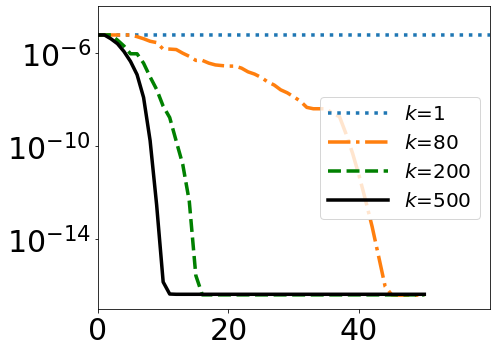

In [200]:
plt.rcParams['figure.figsize'] = (7, 5) #graph-size
params = {'legend.fontsize': 20,
          'legend.handlelength': 3} #legend-size
plt.rcParams.update(params)
plt.plot(grres_k[0],':', linewidth=3.5,label='$k$=1')
plt.plot(grres_k[1],'-.', linewidth=3.5,label="$k$=80")
plt.plot(grres_k[2],'--g',linewidth=3.5,label="$k$=200")
plt.plot(grres_k[3],'-k',linewidth=3.5,label="$k$=500")
#plt.plot(res_k[4],'-^r',linewidth=2.5,label="$k$=1000")
plt.tick_params(labelsize=30)
plt.legend()
plt.yscale("log")

plt.yticks([1e-14,1e-10,1e-6])
plt.ylim(1e-17,1e-4)
plt.xticks([0,20,40])
plt.xlim([0,60])
plt.tight_layout()
plt.savefig('graph_gr/MINIST.res.png')
plt.savefig('graph_gr/MNIST.res.pdf',format='pdf')

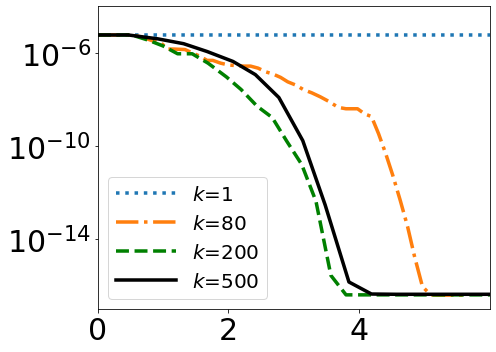

In [199]:
plt.rcParams['figure.figsize'] = (7, 5) #graph-size
params = {'legend.fontsize': 20,
          'legend.handlelength': 3} #legend-size
plt.rcParams.update(params)
plt.plot(grtime_k[0],grres_k[0],':', linewidth=3.5,label='$k$=1')
plt.plot(grtime_k[1],grres_k[1],'-.', linewidth=3.5,label="$k$=80")
plt.plot(grtime_k[2],grres_k[2],'--g',linewidth=3.5,label="$k$=200")
plt.plot(grtime_k[3], grres_k[3],'-k',linewidth=3.5,label="$k$=500")
#plt.plot(time_k[4], res_k[4],'-^r',linewidth=2.5,label="$k$=1000")
plt.tick_params(labelsize=30)
plt.legend()
plt.yscale("log")

plt.yticks([1e-14,1e-10,1e-6])
plt.ylim(1e-17,1e-4)
plt.xticks([0,2,4])
plt.xlim(0,6)

plt.tight_layout()
plt.savefig('graph_gr/MNIST.time.png')
plt.savefig('graph_gr/MNIST.time.pdf',format='pdf')

In [758]:
blockbfgsv1, time_blockbfgsv1=BlockBFGSv1(x1[-1].copy(),100000,200,1, True)

5.913951389978557e-06
2.712552631604787e-08
6.911442792525946e-14
6.911442792525946e-14
6.911442792525946e-14
6.911442792525946e-14
8.465408413218107e-12
8.465408413218107e-12
8.465408413218107e-12
8.465408413218107e-12
8.465408413218107e-12


In [762]:
blockbfgs, time_blockbfgs=BlockBFGS(x1[-1].copy(),10000,1000,200,100,True)

5.913943667197933e-06
1.6459507256820064e-08
2.3637611557105303e-15
3.7219775440728386e-17
3.7219775440728386e-17
3.7219775440728386e-17
3.7219775440728386e-17
3.7219775440728386e-17
3.7219775440728386e-17
3.7219775440728386e-17
3.7219775440728386e-17


In [313]:
_,_=BlockDFP(x1[-1].copy(),10000,1000,200,70,True)

5.913943667197933e-06
2.4044648266043223e-07
7.096073318729692e-08
2.072408170560548e-08
6.670636183809605e-09
2.0378443454470095e-09
6.050485250303958e-10


In [316]:
_,_=BlockDFPv1(x1[-1].copy(),10000,1000,200,70,True)

5.913943667197933e-06
2.0661105483216575e-07
201.53121509855652
985.0525370662361
167.79923174676753
328.6519138780289
939.605176623158


In [295]:
np.save("data/MNIST_blockDFP_res_200.npy",block_dfp)

In [11]:
blockbfgsv1=np.load("data/MNIST_bfgsv1_res_200.npy")
blockbfgs=np.load("data/MNIST_bfgsv2_res_200.npy")
time_blockbfgsv1=np.load("data/MNIST_bfgsv1_time_200.npy")
time_blockbfgs=np.load("data/MNIST_bfgsv2_time_200.npy")

In [12]:
plt.rcParams['figure.figsize'] = (7, 5) #graph-size
params = {'legend.fontsize': 20,
          'legend.handlelength': 3} #legend-size
plt.rcParams.update(params)
res_gr1=grres_k[0]
res_grk=grres_k[2]
res_ra1=res_k[0]
res_rak=res_k[2]
plt.plot(res_gr1[:80],'-.',linewidth=3.5,label="GrSR1")
plt.plot(res_ra1[:80],':',linewidth=3.5,label="RaSR1")
plt.plot(blockbfgsv1[:80],'--g',linewidth=3.5,label="BlockBFGSv1")
plt.plot(blockbfgs[:80],'-k',linewidth=3.5, label="BlockBFGSv2")

plt.plot(np.arange(0, 70, 5), block_dfp[:70:5],'-+y',linewidth=3.5,ms=10,label="BlockDFP")
plt.plot(np.arange(0, 50, 5), res_grk[:50:5],'-Hb',linewidth=3.5,ms=10,label="GrSR-$k$")
plt.plot(np.arange(0, 50, 5), res_rak[:50:5],'-^r',linewidth=3.5,ms=10,label="RaSR-$k$")


plt.tick_params(labelsize=23) #axis-size
plt.legend(loc="center left") #legend-loc
plt.yscale("log")

plt.yticks([1e-14,1e-10,1e-6])
plt.xticks([0,20,40])
plt.xlim(0,60)
plt.tight_layout()
plt.savefig('Graph/MNIST.res.png')
plt.savefig('Graph/MNIST.res.pdf',format='pdf')

NameError: name 'grres_k' is not defined

In [13]:
plt.rcParams['figure.figsize'] = (7, 5) #graph-size
params = {'legend.fontsize': 20,
          'legend.handlelength': 3} #legend-size
plt.rcParams.update(params)
res_gr1=grres_k[0]
time_gr1=grtime_k[0]
res_grk=grres_k[2]
time_grk=grtime_k[2]
res_ra1=res_k[0]
time_ra1=time_k[0]
res_rak=res_k[2]
time_rak=time_k[2]
plt.plot(time_gr1[:160],res_gr1[:160],'-.',linewidth=3.5,label="GrSR1")
plt.plot(time_ra1[:160],res_ra1[:160],':',linewidth=3.5,label="RaSR1")
plt.plot(time_blockbfgsv1[:80],blockbfgsv1[:80],'--g',linewidth=3.5,label="BlockBFGSv1")
plt.plot(time_blockbfgs[:80],blockbfgs[:80],'-k',linewidth=3.5, label="BlockBFGSv2")
plt.plot(time_blockbfgs[:70:5], block_dfp[:70:5],'-+y',linewidth=3.5,ms=10,label="BlockDFP")
plt.plot(time_grk[:50:5], res_grk[:50:5],'-Hb',linewidth=3.5,ms=10,label="GrSR-$k$")
plt.plot(time_grk[:50:5], res_rak[:50:5],'-^r',linewidth=3.5,ms=10,label="RaSR-$k$")


plt.tick_params(labelsize=30) #axis-size
plt.legend(loc="center right") #legend-loc
plt.yscale("log")

plt.yticks([1e-14,1e-10,1e-6])
plt.xticks([0,3,6])
plt.xlim(0,8)
plt.tight_layout()
plt.savefig('Graph/MNIST.time.png')
plt.savefig('Graph/MNIST.time.pdf',format='pdf')

NameError: name 'grres_k' is not defined

In [778]:
K_LIST=[0,80,200,500,1000]

### Data Store

In [779]:
for i in range(5):
    file_name_res= "data/"+"MNIST_ra_res_"+str(K_LIST[i])+".npy"
    file_name_time="data/"+"MNIST_ra_time_"+str(K_LIST[i])+".npy"
    np.save(file_name_res,res_k[i])
    np.save(file_name_time,time_k[i])

for i in range(4):
    file_name_res= "data/"+"MNIST_gr_res_"+str(K_LIST[i])+".npy"
    file_name_time="data/"+"MNIST_gr_time_"+str(K_LIST[i])+".npy"
    np.save(file_name_res,grres_k[i])
    np.save(file_name_time,grtime_k[i])

file_name_res= "data/"+"MNIST_bfgsv1_res_200"+".npy"
file_name_time="data/"+"MNIST_bfgsv1_time_200"+".npy"
np.save(file_name_res,blockbfgsv1)
np.save(file_name_time,time_blockbfgsv1)

file_name_res= "data/"+"MNIST_bfgsv2_res_200"+".npy"
file_name_time="data/"+"MNIST_bfgsv2_time_200"+".npy"
np.save(file_name_res,blockbfgs)
np.save(file_name_time,time_blockbfgs)

# SIDO0

In [229]:
m = loadmat('sido0.mat')
A0=m['A'].toarray().astype("float")
b1=np.array(m['b']).astype("float")
d=A0.shape[1]
N=A0.shape[0]
oracle=Logistic1(A0,b1,0.00001)

In [230]:
x0=np.zeros([oracle.d,1])

In [231]:
res,x_out=Newton(x0,10)

In [857]:
K_LIST=[1, 80, 200, 500, 1000]
grres_k=[]
grtime_k=[]
T= [150,100,100,50,30]
L_list=[500,500,500,5000,5000]
M_list=[10,10,30,100,100]
i=0
for k in K_LIST:
    print("k="+str(k))
    res_l, time_l=grsrk_sol(x_out[-3].copy(), L_list[i], M_list[i], k ,T[i],True)
    grres_k.append(res_l)
    grtime_k.append(time_l)
    i+=1

k=1
0.0019637456776082224
0.0019583775941512394
0.001952876830504871
0.001946481645951443
0.0019363517629341076
0.0019235244038019943
0.0019059691482245873
0.0018949500687553788
0.0018806461470863354
0.001865577769096347
0.0018411633351658122
0.0018174631488437718
0.001792928508078322
0.0017691072123256777
0.001755394063047526
0.0017310355572860564
k=80
0.0019637456776082224
0.0002642409629339742
0.00017916228041560566
0.00014426407374270412
0.00010304885500914151
6.959304213732306e-05
3.1631623645957144e-05
4.7389214388169875e-06
2.408697088884048e-06
1.5432156347640899e-06
1.1750409834776343e-06
k=200
0.0019637456776082224
0.0001555398516582943
7.573090330364714e-05
1.5868769701653713e-05
4.679355252574925e-06
1.1236152868348663e-06
4.301487009312184e-09
1.9003465068508865e-13
4.830719390629944e-18
4.830719390629944e-18
4.830719390629944e-18
k=500
0.0019642301187860972
6.655075024110811e-05
8.947893350481183e-06
1.6354370648738788e-07
4.653328985059664e-14
1.5885423075321012e-17
k=10

In [235]:
res_l, time_l=grsrk_sol(x_out[-3].copy(), 5000, 100, 1000 ,30,True)

0.0019642301187860972
9.836289390859468e-06
1.9706464568263148e-11
8.45844285987646e-18


In [253]:
np.save("data/SIDO0_gr_res_1000.npy",res_l)
np.save("data/SIDO0_gr_time_1000.npy",np.array(time_l)*1.4)

In [296]:
grres_k=[]
grtime_k=[]
K_LIST=[1, 80, 200, 500, 1000]
for i in range(len(K_LIST)):
    file_name_res= "data/"+"SIDO0_gr_res_"+str(K_LIST[i])+".npy"
    file_name_time="data/"+"SIDO0_gr_time_"+str(K_LIST[i])+".npy"
    grres_k.append(np.load(file_name_res))
    grtime_k.append(np.load(file_name_time))

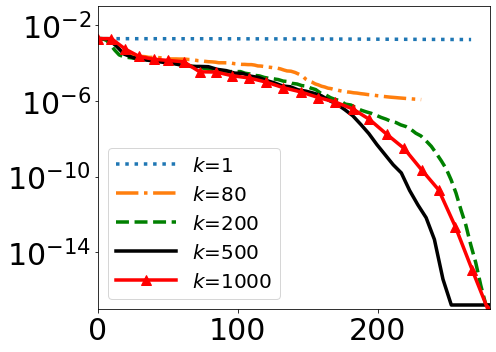

In [264]:
plt.rcParams['figure.figsize'] = (7, 5) #graph-size
params = {'legend.fontsize': 20,
          'legend.handlelength': 3} #legend-size
plt.rcParams.update(params)
plt.plot(grtime_k[0],grres_k[0],':', linewidth=3.5,label='$k$=1')
plt.plot(grtime_k[1],grres_k[1],'-.', linewidth=3.5,label="$k$=80")
plt.plot(grtime_k[2],grres_k[2],'--g',linewidth=3.5,label="$k$=200")
plt.plot(grtime_k[3], grres_k[3],'-k',linewidth=3.5,label="$k$=500")
plt.plot(grtime_k[4], grres_k[4],'-^r',linewidth=3.5,ms=10,label="$k$=1000")
plt.tick_params(labelsize=30)
plt.legend()
plt.yscale("log")


plt.yticks([1e-14,1e-10,1e-6,1e-2])
plt.ylim(1e-17,1e-1)
plt.xticks([0,100,200])
plt.xlim(0,280)

plt.tight_layout()
plt.savefig('graph_gr/sido0.time.png')
plt.savefig('graph_gr/sido0.time.pdf',format='pdf')

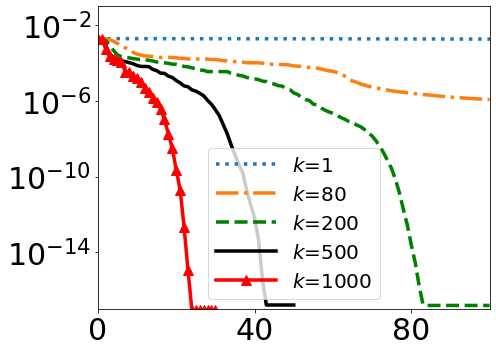

In [265]:
plt.rcParams['figure.figsize'] = (7, 5) #graph-size
params = {'legend.fontsize': 20,
          'legend.handlelength': 3} #legend-size
plt.rcParams.update(params)
plt.plot(grres_k[0],':', linewidth=3.5,label='$k$=1')
plt.plot(grres_k[1],'-.', linewidth=3.5,label="$k$=80")
plt.plot(grres_k[2],'--g',linewidth=3.5,label="$k$=200")
plt.plot(grres_k[3],'-k',linewidth=3.5,label="$k$=500")
plt.plot(grres_k[4],'-^r',linewidth=3.5,ms=10,label="$k$=1000")
plt.tick_params(labelsize=30)
plt.legend()
plt.yscale("log")


plt.yticks([1e-14,1e-10,1e-6,1e-2])
plt.ylim(1e-17,1e-1)
plt.xticks([0,40,80])
plt.xlim(0,100)

plt.tight_layout()
#plt.savefig('graph_gr/sido0.time.png')
plt.savefig('graph_gr/sido0.res.pdf',format='pdf')

In [ ]:
K_LIST=[1, 80, 200, 500, 1000]
res_k=[]
time_k=[]
T= [150,100,100,50,50]
L_list=[1000,1000,1000,5000,5000]
M_list=[10,10,10,100,100]
i=0
for k in K_LIST:
    print("k="+str(k))
    res_l, time_l=rasrk_practical_sol(x_out[-3].copy(), L_list[i], M_list[i], k ,T[i],True)
    res_k.append(res_l)
    time_k.append(time_l)
    i+=1

k=1
0.001964014805417176
0.0010525645210673778
0.0009137474178752693
0.0007642722275131226
0.0005284379328941113
0.00044956842636982217
0.0003708437579927913
0.00033367366322748594
0.0003100475523499837
0.000268263738950183
0.00024243032219791605
0.00023453929120885553
0.0002275982527739663
0.00022566300347193799
0.00021849657529597423
0.0002145580636339837
k=80
0.001964014805417176
0.00011388493187708653
7.361250306012547e-05
5.5715218290461395e-05
4.4097629013055985e-05
3.4614542085567235e-05
2.5969139405950882e-05
1.6408396923864215e-05
9.098843698779975e-06
3.4755652360842543e-06
9.509422581153865e-07
k=200
0.001964014805417176
6.752312606014352e-05
3.507694463922404e-05
1.448015904465649e-05
1.8801511181185498e-06
1.7508640518666906e-08
2.0174918555239198e-10
8.641618292569669e-15
8.641618292569669e-15
8.641618292569669e-15
8.641618292569669e-15
k=500
0.0019642301187860972
4.2582924719844487e-05
1.5916963349145164e-05
2.310001244538167e-06
5.740100849545388e-09
3.964062906995267e-

In [ ]:
res_k[0],time_k[0]=rasrk_practical_sol(x_out[-3].copy(), 1000, 10, 1 ,180,True)
res_k[1],time_k[1]=rasrk_practical_sol(x_out[-3].copy(), 1000, 10, 80 ,160,True)

0.001964014805417176
0.000737427732759499
0.0005818893058767906
0.0005124586130209129
0.0004090321064886465
0.0004014545145907164
0.000358565902831929
0.0003131314835633388
0.00030065989455509785
0.00026840305190677116
0.0002568215341123154
0.00024741593023403326
0.0002319839639485705
0.00022666739341324456
0.00022401935876466473
0.00021258439448566235
0.00020985560327152575
0.0002069459651593117
0.00020135937408121305
0.001964014805417176
0.00011392753095945537
7.494312606021864e-05
5.7779799361614475e-05
4.54006294640732e-05
3.442474634820807e-05
2.5418348575945993e-05
1.5750598024955995e-05
8.049415461617219e-06
3.085528855655822e-06
7.061271933716278e-07
7.197890515339422e-08
2.18980318034041e-09
9.500023825178257e-12
2.8023190468563786e-15
5.013497675906652e-18
5.013497675906652e-18


In [ ]:
res_k[0],time_k[0]=rasrk_practical_sol(x_out[-3].copy(), 1000, 100, 1 ,250,True)

0.001964014805417176
0.0008803036906233535
0.0005826581107430696
0.00045953589393170227
0.0004330917508151194
0.00038473563380425683
0.0003650145312557699
0.0003314215574117128
0.0003084101880503613
0.0002883963217139378
0.0002695520484050897
0.00026156195292953676
0.0002507062746745598
0.00024641550671263967
0.00024261703299815752
0.00024261703299815752
0.00023466411266018068
0.00022973249326537645
0.00022419455622972625
0.00021639588923804063
0.00020467052178956634
0.0001942604015667935
0.0001942604015667935
0.00019328102598152721
0.00018895923066210171
0.00018895923066210171


In [ ]:
for i in range(len(K_LIST)):
    file_name_res= "data/"+"sido0_res_"+str(K_LIST[i])+".npy"
    file_name_time="data/"+"sido0_time_"+str(K_LIST[i])+".npy"
    np.save(file_name_res,res_k[i])
    np.save(file_name_time,time_k[i])

In [297]:
res_k=[]
time_k=[]
K_LIST=[1, 80, 200, 500, 1000]
for i in range(len(K_LIST)):
    file_name_res= "data/"+"SIDO0_res_"+str(K_LIST[i])+".npy"
    file_name_time="data/"+"SIDO0_time_"+str(K_LIST[i])+".npy"
    res_k.append(np.load(file_name_res))
    time_k.append(np.load(file_name_time))

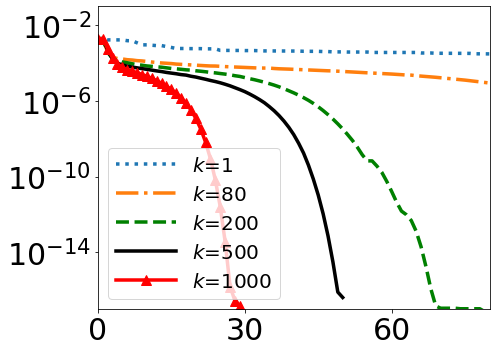

In [262]:
plt.rcParams['figure.figsize'] = (7, 5) #graph-size
params = {'legend.fontsize': 20,
          'legend.handlelength': 3} #legend-size
plt.rcParams.update(params)
plt.plot(res_k[0],':', linewidth=3.5,label='$k$=1')
plt.plot(res_k[1],'-.', linewidth=3.5,label="$k$=80")
plt.plot(res_k[2],'--g',linewidth=3.5,label="$k$=200")
plt.plot(res_k[3],'-k',linewidth=3.5,ms=10,label="$k$=500")
plt.plot(res_k[4],'-^r',linewidth=3.5,ms=10,label="$k$=1000")
plt.tick_params(labelsize=30)
plt.legend()
plt.yscale("log")

plt.yticks([1e-14,1e-10,1e-6,1e-2])
plt.ylim(1e-17,1e-1)
plt.xticks([0,30,60])
plt.xlim([0,80])
plt.tight_layout()
plt.savefig('new_graph/sido0.res.png')
plt.savefig('new_graph/sido0.res.pdf',format='pdf')

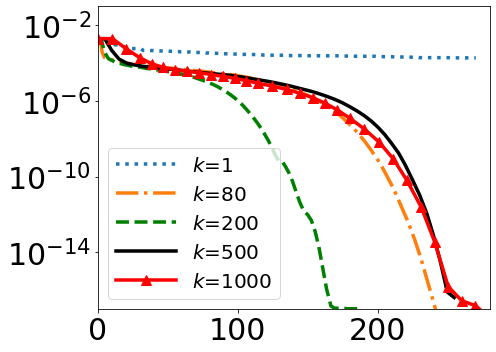

In [263]:
plt.rcParams['figure.figsize'] = (7, 5) #graph-size
params = {'legend.fontsize': 20,
          'legend.handlelength': 3} #legend-size
plt.rcParams.update(params)
plt.plot(time_k[0],res_k[0],':', linewidth=3.5,label='$k$=1')
plt.plot(time_k[1],res_k[1],'-.', linewidth=3.5,label="$k$=80")
plt.plot(time_k[2],res_k[2],'--g',linewidth=3.5,label="$k$=200")
plt.plot(time_k[3], res_k[3],'-k',linewidth=3.5,label="$k$=500")
plt.plot(time_k[4], res_k[4],'-^r',linewidth=3.5,ms=10,label="$k$=1000")
plt.tick_params(labelsize=30)
plt.legend()
plt.yscale("log")


plt.yticks([1e-14,1e-10,1e-6,1e-2])
plt.ylim(1e-17,1e-1)
plt.xticks([0,100,200])
plt.xlim(0,280)

plt.tight_layout()
plt.savefig('new_graph/sido0.time.png')
plt.savefig('new_graph/sido0.time.pdf',format='pdf')

In [268]:
sido0_res_blockbfgs,sido0_time_blockbfgs=BlockBFGS(x_out[-3].copy(),1000,100,200,100,True)
np.save("data/sido0_bfgsv2_res_200.npy",sido0_res_blockbfgs)
np.save("data/sido0_bfgsv2_time_200.npy",sido0_time_blockbfgs)

0.001964014805417176
7.420376728510236e-05
4.488642606139185e-05
2.7008915483119362e-05
1.2523394375598522e-05
4.2114129079341075e-06
3.497217791665331e-06
3.497217791665331e-06
3.497217791665331e-06
3.497217791665331e-06
3.497217791665331e-06


In [269]:
sido0_res_blockbfgsv1,sido0_time_blockbfgsv1=BlockBFGSv1(x_out[-3].copy(),1000,200,100)
np.save("data/sido0_bfgsv1_res_200.npy",sido0_res_blockbfgsv1)
np.save("data/sido0_bfgsv1_time_200.npy",sido0_time_blockbfgsv1)

0.001964014805417176
7.653695276889369e-05
4.774907634509209e-05
2.5919406718070745e-05
1.1884655876436338e-05
3.788980772827564e-06
1.5821679473346586e-05
1.5821679473346586e-05
1.5821679473346586e-05
1.5821679473346586e-05
1.5821679473346586e-05


In [270]:
sido0_res_blockDFP,_=BlockDFP(x_out[-3].copy(),1000,100,200,50,True)
np.save("data/sido0_DFP_res_200.npy",sido0_res_blockDFP)

0.001964014805417176
9.777651837183315e-05
7.13092934352796e-05
5.988863972655535e-05
5.2559249341990044e-05


In [301]:
np.array(sido0_res_blockDFP).repeat(2)

array([1.96428395e-03, 1.96428395e-03, 1.96401481e-03, 1.96401481e-03,
       3.84292791e-04, 3.84292791e-04, 1.71534205e-04, 1.71534205e-04,
       1.48703356e-04, 1.48703356e-04, 1.39076090e-04, 1.39076090e-04,
       1.25935604e-04, 1.25935604e-04, 1.20015005e-04, 1.20015005e-04,
       1.12268638e-04, 1.12268638e-04, 1.07309690e-04, 1.07309690e-04,
       1.01601379e-04, 1.01601379e-04, 9.77765184e-05, 9.77765184e-05,
       9.29415297e-05, 9.29415297e-05, 8.77737929e-05, 8.77737929e-05,
       8.54585478e-05, 8.54585478e-05, 8.34936627e-05, 8.34936627e-05,
       7.99917848e-05, 7.99917848e-05, 7.89229306e-05, 7.89229306e-05,
       7.81383293e-05, 7.81383293e-05, 7.47721355e-05, 7.47721355e-05,
       7.37980305e-05, 7.37980305e-05, 7.13092934e-05, 7.13092934e-05,
       6.99846604e-05, 6.99846604e-05, 7.03281138e-05, 7.03281138e-05,
       6.77228548e-05, 6.77228548e-05, 6.49139254e-05, 6.49139254e-05,
       6.61573745e-05, 6.61573745e-05, 6.44958743e-05, 6.44958743e-05,
      

In [303]:
for i in range(40):
    sido0_res_blockDFP.append(sido0_res_blockDFP[-1])

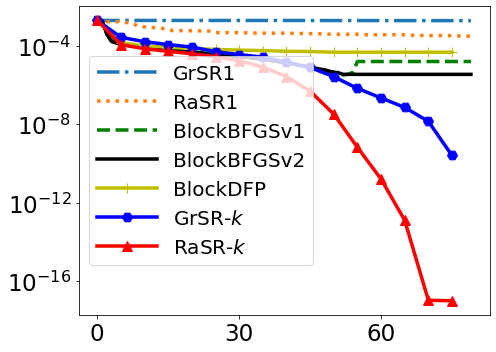

In [306]:
plt.rcParams['figure.figsize'] = (7, 5) #graph-size
params = {'legend.fontsize': 20,
          'legend.handlelength': 3} #legend-size
plt.rcParams.update(params)
res_gr1=grres_k[0]
res_grk=grres_k[2]
res_ra1=res_k[0]
res_rak=res_k[2]
plt.plot(res_gr1[:80],'-.',linewidth=3.5,label="GrSR1")
plt.plot(res_ra1[:80],':',linewidth=3.5,label="RaSR1")
plt.plot(sido0_res_blockbfgsv1[:80],'--g',linewidth=3.5,label="BlockBFGSv1")
plt.plot(sido0_res_blockbfgs[:80],'-k',linewidth=3.5, label="BlockBFGSv2")
plt.plot(np.arange(0, 80, 5), sido0_res_blockDFP[:80:5],'-+y',linewidth=3.5,ms=10,label="BlockDFP")
plt.plot(np.arange(0, 80, 5), res_grk[:80:5],'-Hb',linewidth=3.5,ms=10,label="GrSR-$k$")
plt.plot(np.arange(0, 80, 5), res_rak[:80:5],'-^r',linewidth=3.5,ms=10,label="RaSR-$k$")


plt.tick_params(labelsize=23) #axis-size
plt.legend(loc="center left") #legend-loc
plt.yscale("log")

plt.yticks([1e-16,1e-12,1e-8,1e-4])
plt.xticks([0,30,60])
plt.tight_layout()
plt.savefig('Graph/sido0.res.png')
plt.savefig('Graph/sido0.res.pdf',format='pdf')

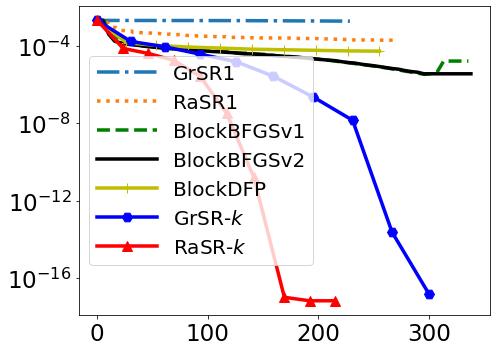

In [281]:
plt.rcParams['figure.figsize'] = (7, 5) #graph-size
params = {'legend.fontsize': 20,
          'legend.handlelength': 3} #legend-size
plt.rcParams.update(params)
res_gr1=grres_k[0]
time_gr1=grtime_k[0]
res_grk=grres_k[2]
time_grk=grtime_k[2]
res_ra1=res_k[0]
time_ra1=time_k[0]
res_rak=res_k[2]
time_rak=time_k[2]

plt.plot(time_gr1[:130],res_gr1[:130],'-.',linewidth=3.5,label="GrSR1")
plt.plot(time_ra1[:260],res_ra1[:260],':',linewidth=3.5,label="RaSR1")
plt.plot(sido0_time_blockbfgsv1[:60],sido0_res_blockbfgsv1[:60],'--g',linewidth=3.5,label="BlockBFGSv1")
plt.plot(sido0_time_blockbfgs[:60],sido0_res_blockbfgs[:60],'-k',linewidth=3.5, label="BlockBFGSv2")
plt.plot(sido0_time_blockbfgs[:50:5],sido0_res_blockDFP[:50:5],'-+y',linewidth=3.5,ms=10, label="BlockDFP")


plt.plot(time_grk[:100:10], res_grk[:100:10],'-Hb',linewidth=3.5,ms=10,label="GrSR-$k$")
plt.plot(time_rak[:100:10],res_rak[:100:10],'-^r',linewidth=3.5,ms=10,label="RaSR-$k$")


plt.tick_params(labelsize=23) #axis-size
plt.legend(loc="center left") #legend-loc
plt.yscale("log")

plt.yticks([1e-16,1e-12,1e-8,1e-4])
plt.tight_layout()
plt.savefig('Graph/sido0.time.png')
plt.savefig('Graph/sido0.time.pdf',format='pdf')

# w8a

In [ ]:
m = loadmat('w8a.mat')
A0=np.array(m['A']).astype("float")
b1=np.array(m['b']).astype("float")
d=A0.shape[1]
oracle=Logistic1(A0,b1,0.00001)

In [ ]:
x0=np.zeros([oracle.d,1])

In [ ]:
res,x1=Newton(x0,8)

In [ ]:
res1_srk,time_srk=rasrk_sol(x1.copy(),1000,10,10,300,True)

3.626200683685035e-05
1.930771997236032e-07
2.2992287671747248e-18
2.2992287671747248e-18
2.2992287671747248e-18
2.2992287671747248e-18
2.2992287671747248e-18


In [ ]:
w8a_res_rasr5, w8a_time_rasr5=rasrk_sol(x1.copy(),1000,10, 5 ,300,True)

3.626200683685035e-05
2.0015082624938708e-05
1.5283332300202105e-10
2.642328246285431e-18
2.642328246285431e-18
2.6353140707879097e-18
2.6353140707879097e-18


In [ ]:
res1_sr1,time_sr1=rasrk_sol(x1.copy(),10,20,1,600,True)

3.62581547674662e-05
3.527911875268382e-05
3.520573523710136e-05
3.518559889780947e-05
3.194659787092956e-05
2.7634900195414447e-05
2.0603349577053396e-05
9.503913352200358e-06
4.061187011119546e-06
1.6159409806789275e-06
3.498942111011389e-07
2.7151443879787366e-08
4.9148773240262e-10


In [ ]:
grsr1,tgrsr1=grsrk_sol(x1.copy(),1000,10,1,300,True)

3.626200683685035e-05
2.734993085161132e-05
1.6117989211487898e-05
8.483728374457507e-06
4.7987301327762845e-06
2.9048599463977892e-06
1.7278684781443186e-07


In [ ]:
grsrk,tgrsrk=grsrk_sol(x1.copy(),1000,10,10,300,True)

3.626200683685035e-05
3.3978074571410267e-18
3.3978074571410267e-18
3.3978074571410267e-18
3.3978074571410267e-18
3.3978074571410267e-18
3.3978074571410267e-18


In [ ]:
w8a_res_grsr5, w8a_time_grsr5=grsrk_sol(x1.copy(),1000,10,5,300,True)

3.626200683685035e-05
2.9032204160268204e-06
3.0550492844600923e-18
3.0550492844600923e-18
3.0550492844600923e-18
3.0550492844600923e-18
3.0550492844600923e-18


In [ ]:
blockbfgsv1,time_blockbfgsv1=BlockBFGSv1(x1.copy(),100,10,500)

3.626165656597196e-05
9.802293568308899e-06
1.0981679045135282e-07
3.1393495570876395e-11
2.8675904674764567e-11
2.8675904674764567e-11
2.8675904674764567e-11
2.8675904674764567e-11
2.8675904674764567e-11
2.8675904674764567e-11
2.8675904674764567e-11


In [ ]:
w8a_res_blockbfgsv1_5, w8a_time_blockbfgsv1_5=BlockBFGSv1(x1.copy(),100,5,500)

3.626165656597196e-05
2.5253234961162018e-05
5.483845526867382e-06
4.644481429219219e-07
7.835104048498922e-09
3.830239606516222e-11
3.407546402731751e-11
2.6479273328515206e-11
2.6479273328515206e-11
2.6479273328515206e-11
2.6479273328515206e-11


In [ ]:
blockbfgsk,time_blockbfgsk=BlockBFGS(x1.copy(),100,2,10,500,True)

3.626165656597196e-05
7.6166915072657575e-06
6.729746823059217e-08
9.9246960415952e-12
6.401458236480934e-16
6.401458236480934e-16
6.401458236480934e-16
6.401458236480934e-16
6.401458236480934e-16
6.401458236480934e-16
6.401458236480934e-16


In [ ]:
w8a_res_blockbfgs5,w8a_time_blockbfgs5=BlockBFGS(x1.copy(),100,2,5,500,True)

3.626165656597196e-05
2.971622739781529e-05
5.904808655927935e-06
4.4489294330598916e-07
3.744124887317408e-09
4.73545260070233e-12
5.970891054711143e-16
3.741325657036531e-18
2.7466945895949276e-18
2.7368720220427503e-18
2.7368720220427503e-18


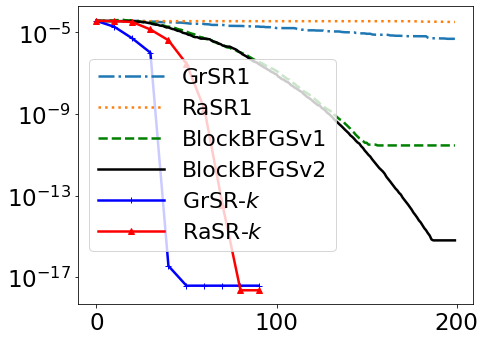

In [ ]:
plt.rcParams['figure.figsize'] = (7, 5) #graph-size
params = {'legend.fontsize': 22,
          'legend.handlelength': 3} #legend-size
plt.rcParams.update(params)
plt.plot(grsr1[:200],'-.',linewidth=2.5,label="GrSR1")
plt.plot(res1_sr1[:200],':',linewidth=2.5,label="RaSR1")
plt.plot(blockbfgsv1[:200],'--g',linewidth=2.5,label="BlockBFGSv1")
plt.plot(blockbfgsk[:200],'-k',linewidth=2.5, label="BlockBFGSv2")
plt.plot(np.arange(0, 100, 10), grsrk[:100:10],'-+b',linewidth=2.5,label="GrSR-$k$")
plt.plot(np.arange(0, 100, 10),res1_srk[:100:10],'-^r',linewidth=2.5,label="RaSR-$k$")


plt.tick_params(labelsize=23) #axis-size
plt.legend(loc="center left") #legend-loc
plt.yscale("log")

plt.yticks([1e-17,1e-13,1e-9,1e-5])
plt.xticks([0,100,200])
plt.tight_layout()
plt.savefig('blockquasiimg/w8a.res.png')
plt.savefig('blockquasiimg/w8a.res.pdf',format='pdf')

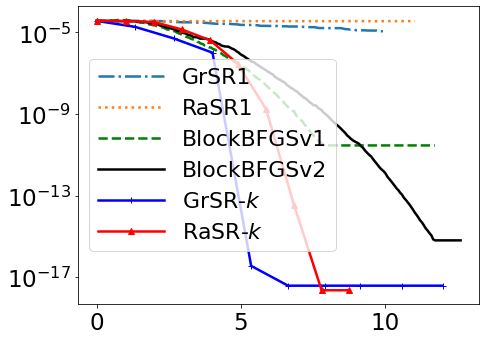

In [ ]:
plt.rcParams['figure.figsize'] = (7, 5) #graph-size
params = {'legend.fontsize': 22,
          'legend.handlelength': 3} #legend-size
plt.rcParams.update(params)
plt.plot(tgrsr1[:130],grsr1[:130],'-.',linewidth=2.5,label="GrSR1")
plt.plot(time_sr1[:130],res1_sr1[:130],':',linewidth=2.5,label="RaSR1")
plt.plot(time_blockbfgsv1[:250],blockbfgsv1[:250],'--g',linewidth=2.5,label="BlockBFGSv1")
plt.plot(time_blockbfgsk[:200],blockbfgsk[:200],'-k',linewidth=2.5, label="BlockBFGSv2")
plt.plot(tgrsrk[:100:10], grsrk[:100:10],'-+b',linewidth=2.5,label="GrSR-$k$")
plt.plot(time_srk[:100:10],res1_srk[:100:10],'-^r',linewidth=2.5,label="RaSR-$k$")


plt.tick_params(labelsize=23) #axis-size
plt.legend(loc="center left") #legend-loc
plt.yscale("log")

plt.yticks([1e-17,1e-13,1e-9,1e-5])
plt.tight_layout()
plt.savefig('blockquasiimg/w8a.time.png')
plt.savefig('blockquasiimg/w8a.time.pdf',format='pdf')
#plt.xticks([0,2,4])

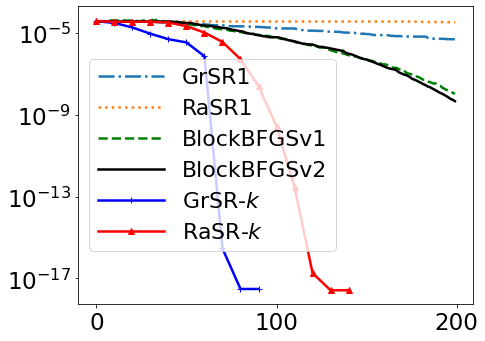

In [ ]:
plt.rcParams['figure.figsize'] = (7, 5) #graph-size
params = {'legend.fontsize': 22,
          'legend.handlelength': 3} #legend-size
plt.rcParams.update(params)
plt.plot(grsr1[:200],'-.',linewidth=2.5,label="GrSR1")
plt.plot(res1_sr1[:200],':',linewidth=2.5,label="RaSR1")
plt.plot(w8a_res_blockbfgsv1_5[:200],'--g',linewidth=2.5,label="BlockBFGSv1")
plt.plot(w8a_res_blockbfgs5[:200],'-k',linewidth=2.5, label="BlockBFGSv2")
plt.plot(np.arange(0, 100, 10), w8a_res_grsr5[:100:10],'-+b',linewidth=2.5,label="GrSR-$k$")
plt.plot(np.arange(0, 150, 10),w8a_res_rasr5[:150:10],'-^r',linewidth=2.5,label="RaSR-$k$")


plt.tick_params(labelsize=23) #axis-size
plt.legend(loc="center left") #legend-loc
plt.yscale("log")

plt.yticks([1e-17,1e-13,1e-9,1e-5])
plt.xticks([0,100,200])
plt.tight_layout()
plt.savefig('blockquasiimg/w8a.res_5.png')
plt.savefig('blockquasiimg/w8a.res_5.pdf',format='pdf')

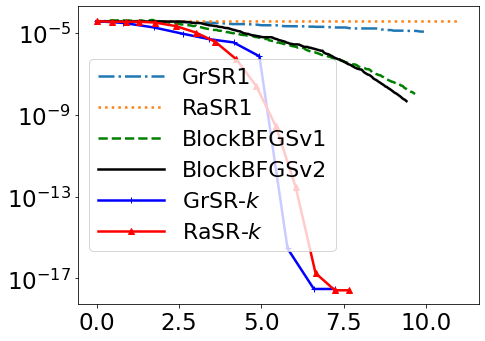

In [ ]:
plt.rcParams['figure.figsize'] = (7, 5) #graph-size
params = {'legend.fontsize': 22,
          'legend.handlelength': 3} #legend-size
plt.rcParams.update(params)
plt.plot(tgrsr1[:130],grsr1[:130],'-.',linewidth=2.5,label="GrSR1")
plt.plot(time_sr1[:130],res1_sr1[:130],':',linewidth=2.5,label="RaSR1")
plt.plot(w8a_time_blockbfgsv1_5[:200],w8a_res_blockbfgsv1_5[:200],'--g',linewidth=2.5,label="BlockBFGSv1")
plt.plot(w8a_time_blockbfgs5[:200],w8a_res_blockbfgs5[:200],'-k',linewidth=2.5, label="BlockBFGSv2")
plt.plot(w8a_time_grsr5[:100:10], w8a_res_grsr5[:100:10],'-+b',linewidth=2.5,label="GrSR-$k$")
plt.plot(w8a_time_rasr5[:150:10],w8a_res_rasr5[:150:10],'-^r',linewidth=2.5,label="RaSR-$k$")


plt.tick_params(labelsize=23) #axis-size
plt.legend(loc="center left") #legend-loc
plt.yscale("log")

plt.yticks([1e-17,1e-13,1e-9,1e-5])
plt.tight_layout()
plt.savefig('blockquasiimg/w8a.time_5.png')
plt.savefig('blockquasiimg/w8a.time_5.pdf',format='pdf')

# a9a

In [86]:
m = loadmat('a9a.mat')
A0=np.array(m['A']).astype("float")
b1=np.array(m['b']).astype("float")
d=A0.shape[1]
oracle=Logistic1(A0,b1,0.00001)

In [87]:
x0=np.zeros([oracle.d,1])

In [129]:
res,x1=Newton(x0,6)

In [136]:
a9a_res_DFP, a9a_time_DFP = BlockDFP(x1[-1],10000,1000,10,2000,1)

6.146844729723167e-06
2.3495387349177642e-06
1.247662148256122e-06
9.477822069876406e-07
6.650347271774828e-07
6.135799225102746e-07
3.868434121370709e-07
2.909017635625461e-07
2.2470783722004872e-07
2.133673279729805e-07
1.8933712368677772e-07
1.8472499708793393e-07
1.558709232715099e-07
1.4638407467495426e-07
1.469668277365983e-07
1.2806449567303282e-07
1.4749505920208765e-07
1.508637341682058e-07
1.2821155670291478e-07
1.2139041089681372e-07
1.2320355330241402e-07
1.1598330604314268e-07
1.1704418296561827e-07
1.0298981596967521e-07
1.0765509730376832e-07
1.198455595544955e-07
8.918818685181384e-08
1.2164920448491708e-07
9.468632915553829e-08
8.417232657179704e-08
8.96027410049059e-08
8.250761264753948e-08
9.157333588796701e-08
7.208541830364287e-08
8.22183413017081e-08
8.372173557029632e-08
7.919459472467291e-08
7.52915152774408e-08
7.584918767451551e-08
7.653089314934658e-08
7.025263701624717e-08
7.820033456774389e-08
7.989371770258125e-08
6.216746717788825e-08
7.000556805871006e-0

In [134]:
a9a_res_DFP, a9a_time_DFP = BlockDFPv1(x1[-1],1000,100,10,1000,1)

6.144004277861764e-06
3.013009736931748e-06
1.5360778580819385e-06
1.0890905274064074e-06
9.24957281910888e-07
6.955698563903372e-07
5.62725807494275e-07
0.25670524299238195
0.012686128599146126
0.00574302899628056
0.00329127092580757
0.002875385079766607
0.0020209965438942553
0.0019316843996563568
0.0018401631592146622
0.0015887429765310227
0.07065091508523795
0.035885641877469954
0.027607550159733343
0.021647078013883488
0.02064391266302786
0.01656798240384594
0.015033067584947038
0.017639450741658725
0.015824843232389082
0.014233292027894666
0.014510167456727955
0.012017712797616256
0.009688266457819193
0.011106454642970123
0.00908118633870153
0.009802304704706057
0.011961644960605256
0.008520622910470092
0.00994121664086759
0.008425666453708203
0.008973842182264026
0.009087212880774393
0.008466089044739123
0.008126548032694388
0.0075232443170381936
0.007144033169631269
0.007932940265383815
0.008766466257775243
0.007567154165143488
0.008807487352068724
0.006895575237999754
0.0073715

In [82]:
a9a_res_fasterBFGS, a9a_time_fasterBFGS = Block_BFGS_Faster(x1[-1],10,1,10,300,1)

0.0029605547131235587
0.0011741048413401243
0.0009877826960858517
0.0004557034367596136
0.0003422606712006644
0.00017987282609394623
0.0001142932658058442
7.373770282427667e-05
7.67061931157665e-05
5.007969461186258e-05
3.0373535457394382e-05
3.0290328020321784e-05
1.7614079731927845e-05
1.35437422716718e-05
1.1997199757818199e-05
4.7626785650124525e-06
4.168828097068259e-07
6.011918829817852e-08
3.260000592475752e-09
2.279618882245782e-12
2.5702258844093212e-17
2.3865799856114848e-17
6.520223577530961e-17
2.347723499874578e-17
2.3198344595198182e-17
2.177078970174131e-17
9.368732112392275e-18
4.0294027854768874e-17
3.3040864998068315e-17
6.254883024146464e-17
8.496569208562703e-18
9.539253800890752e-18
1.2276656857419318e-17
2.429226075773583e-17
4.833187708712856e-17
1.1740356447811506e-17
9.15056990626404e-18
1.2695923471904259e-17
1.047756047125788e-17
6.741922104861805e-18
6.185520046626298e-18
3.997851253732826e-17
7.256017021311031e-18
1.118129542376976e-17
4.149324707353462e-17

In [83]:
a9a_res_fasterBFGS_1, a9a_time_fasterBFGS_1 = Block_BFGS_Faster(x1[-1],10,1,1,300,1)

0.0029605547131235587
0.0015026344028794218
0.0015019762307189645
0.00140033490590759
0.0014381449499232559
0.0012884584920268536
0.0012724634074565977
0.0012267148498809827
0.001052240571969698
0.00103007720715417
0.0009637401371800115
0.0009016474148476322
0.000867792532558285
0.0008355503234271753
0.0007476478576025483
0.000692457646354615
0.0006308559599958731
0.0005618162528929054
0.0005118807888997049
0.00047926236133585045
0.00044629490525801137
0.0004232828510103206
0.00038729027226176894
0.00035655791053866126
0.000330176799663645
0.00030181837116333084
0.0002741093850851902
0.0002495728532749336
0.0002285245835934247
0.00021312997667894264


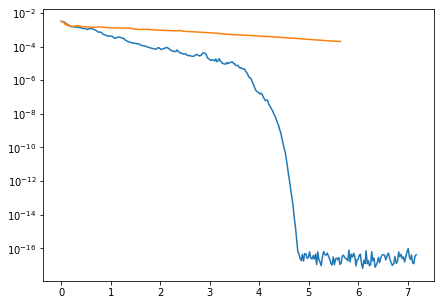

In [85]:
plt.plot(a9a_time_fasterBFGS[:300],a9a_res_fasterBFGS[:300])
plt.plot(a9a_time_fasterBFGS_1,a9a_res_fasterBFGS_1)
plt.yscale("log")

In [67]:
a9a_res_classBFGS,a9a_time_classBFGS = Block_BFGS_Gao(x1[-1],10,1,300)

In [ ]:
a9a_res_rasr1,a9a_time_rasr1=rasrk_sol(x1.copy(),10,20,1,500,True)

0.0029605547131235587
0.001613703507495587
0.00118169699563674
0.0009054536912731289
0.0008281331559088004
0.0006513054010353819
0.0005474470491458396
0.00046051330712232975
0.0003345998331454313
0.00025461113000368416
0.0001355470530017402
0.00012511251133886194
8.50921483076852e-05
6.566772029451527e-05
6.107568422944707e-05
4.118262339439525e-05
3.18416194491214e-05
2.3404060803611195e-05
1.8998273523928984e-05
1.5939122895981346e-05
1.3029454867398784e-05
1.024294688969084e-05
9.639412047585265e-06
7.072526796127307e-06
5.305653948084448e-06
3.826231113329379e-06
2.8003015145385316e-06
2.2136093604274407e-06
1.6898691092558537e-06
1.136092168097974e-06
6.668795926638644e-07
4.0861514656795596e-07
2.3423296296878742e-07
1.1901416302671609e-07
5.542520768009595e-08
1.6764939305761287e-08
6.29612512172025e-09
2.4562334505855324e-09
8.436105887507231e-10
2.1626387587665514e-10
4.42121352553784e-11
4.300709084706695e-12
1.92708766440134e-13
1.4867375222707074e-15
4.731619130305052e-17
1

In [ ]:
a9a_res_grsr1,a9a_time_grsr1=grsrk_sol(x1.copy(),1000,20,1,500,True)

0.003122159973738524
0.00279004427927791
0.00024541801113876554
3.4510308896153476e-06
2.0153731813932324e-07
1.0817382066056767e-11
1.3828199795219978e-17
5.4969853847675364e-18
5.4969853847675364e-18
5.4969853847675364e-18
5.4969853847675364e-18


In [ ]:
a9a_res_rasrk,a9a_time_rasrk=rasrk_sol(x1.copy(),10,20,10,300,True)

0.0029605547131235587
9.44521431390673e-09
6.162103071799667e-18
6.162103071799667e-18
6.162103071799667e-18
6.162103071799667e-18
6.162103071799667e-18


In [ ]:
a9a_res_rasrk_5,a9a_time_rasrk_5=rasrk_sol(x1.copy(),10,20,5,300,True)

0.0029605547131235587
6.480283082018393e-06
3.0953952846993946e-13
7.26474855743686e-18
7.26474855743686e-18
7.26474855743686e-18
7.26474855743686e-18


In [ ]:
a9a_res_grsrk,a9a_time_grsrk=grsrk_sol(x1.copy(),1000,20,10,300,True)

0.003122159973738524
8.58387290078256e-18
7.40445396617019e-18
7.40445396617019e-18
7.40445396617019e-18
7.40445396617019e-18
7.40445396617019e-18


In [ ]:
a9a_res_grsrk_5,a9a_time_grsrk_5=grsrk_sol(x1.copy(),1000,20,5,300,True)

0.003122159973738524
1.1750695145513018e-07
9.748982944766907e-18
8.831529828867209e-18
8.831529828867209e-18
8.831529828867209e-18
8.831529828867209e-18


In [322]:
a9a_res_blockbfgs,a9a_time_blockbfgs=BlockBFGS(x1[-1].copy(),10000,2,10,500,True)

0.0031236446120871644
0.00043637851959603874
9.735374897321024e-05
4.4429911200955534e-05
2.137842586374984e-05
1.234498385346187e-05
6.74818448624294e-06
4.143387496762887e-06
3.718399484993785e-06
3.718399484993785e-06
3.718399484993785e-06
3.718399484993785e-06
3.718399484993785e-06
3.718399484993785e-06
3.718399484993785e-06
3.718399484993785e-06
3.718399484993785e-06
3.718399484993785e-06
3.718399484993785e-06
3.718399484993785e-06
3.718399484993785e-06
3.718399484993785e-06
3.718399484993785e-06
3.718399484993785e-06
3.718399484993785e-06
3.718399484993785e-06
3.718399484993785e-06
3.718399484993785e-06
3.718399484993785e-06
3.718399484993785e-06
3.718399484993785e-06
3.718399484993785e-06
3.718399484993785e-06
3.718399484993785e-06
3.718399484993785e-06
3.718399484993785e-06
3.718399484993785e-06
3.718399484993785e-06
3.718399484993785e-06
3.718399484993785e-06
3.718399484993785e-06
3.718399484993785e-06
3.718399484993785e-06
3.718399484993785e-06
3.718399484993785e-06
3.7183994

In [326]:
_,_=BlockDFPv1(x1[-1].copy(),10000,20000,10,500,True)

0.0031236446120871644
0.0010361352646293999
0.00047820655370171985
0.00030156522436169156
0.0002092358175279055
0.00015508487495774896
0.00013852270568508705
0.0001035782451480179
9.193924044536162e-05
9.228041729062492e-05
9.061305181023695e-05
9.16210261475644e-05
7.722410455203217e-05
7.518088734846007e-05
5.984172406284525e-05
6.0787183236668005e-05
8.209234078496718e-05
7.296240505336209e-05
5.5478667672075234e-05
5.8953882400864396e-05
5.269065570064806e-05
5.801968278693741e-05
6.221315021611865e-05
6.102038326916605e-05
5.2251639398681034e-05
4.7695643444644595e-05
5.1131350755662595e-05
4.814281461370759e-05
4.152059390205591e-05
6.089260959718071e-05
4.098587752527149e-05
4.510392561299108e-05
5.146480043571e-05
3.391259556524496e-05
3.652986510008279e-05
3.440314960320629e-05
2.882013815401408e-05
3.179009240539364e-05
3.474239172082919e-05
3.574048117919353e-05
3.3757192945927467e-05
2.9760731896606393e-05
2.8609335452375076e-05
2.7035641093721114e-05
3.7605876993925834e-05

In [ ]:
a9a_res_blockbfgs_5,a9a_time_blockbfgs_5=BlockBFGS(x1.copy(),10000,20,5,500,True)

0.0031236446120871644
5.623637637381102e-05
1.896431456048163e-05
1.0912832075926476e-05
1.0912832075926476e-05
1.0912832075926476e-05
1.0912832075926476e-05
1.0912832075926476e-05
1.0912832075926476e-05
1.0912832075926476e-05
1.0912832075926476e-05


In [ ]:
a9a_res_blockbfgsv1,a9a_time_blockbfgsv1= BlockBFGSv1(x1.copy(),1000,10,500)

0.003122159973738524
1.023328898175896e-05
1.1729844683071842e-05
1.1729844683071842e-05
1.1729844683071842e-05
1.1729844683071842e-05
1.1729844683071842e-05
1.1729844683071842e-05
1.1729844683071842e-05
1.1729844683071842e-05
1.1729844683071842e-05


In [ ]:
a9a_res_blockbfgsv1_5,a9a_time_blockbfgsv1_5= BlockBFGSv1(x1.copy(),10000,5,500)

0.0031236446120871644
4.746653830176136e-05
6.350385634652749e-06
2.0340961724022913e-06
6.369124834169639e-06
6.369124834169639e-06
6.369124834169639e-06
6.369124834169639e-06
6.369124834169639e-06
6.369124834169639e-06
6.369124834169639e-06


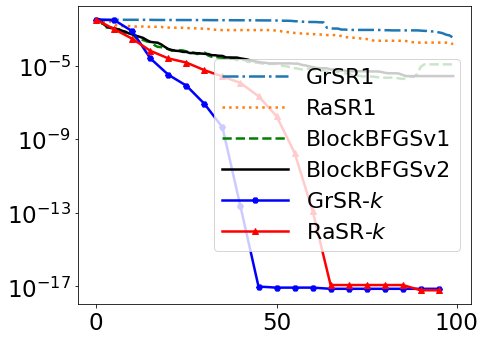

In [ ]:
plt.rcParams['figure.figsize'] = (7, 5) #graph-size
params = {'legend.fontsize': 22,
          'legend.handlelength': 3} #legend-size
plt.rcParams.update(params)
plt.plot(a9a_res_grsr1[:100],'-.',linewidth=2.5,label="GrSR1")
plt.plot(a9a_res_rasr1[:100],':',linewidth=2.5,label="RaSR1")
plt.plot(a9a_res_blockbfgsv1[:100],'--g',linewidth=2.5,label="BlockBFGSv1")
plt.plot(a9a_res_blockbfgs[:100],'-k',linewidth=2.5, label="BlockBFGSv2")
plt.plot(np.arange(0, 100, 5), a9a_res_grsrk[:100:5],'-Hb',linewidth=2.5,label="GrSR-$k$")
plt.plot(np.arange(0, 100, 5),a9a_res_rasrk[:100:5],'-^r',linewidth=2.5,label="RaSR-$k$")


plt.tick_params(labelsize=23) #axis-size
plt.legend(loc="center right") #legend-loc
plt.yscale("log")

plt.yticks([1e-17,1e-13,1e-9,1e-5])
plt.xticks([0,50,100])
plt.tight_layout()
plt.savefig('blockquasiimg/a9a.res.png')
plt.savefig('blockquasiimg/a9a.res.pdf',format='pdf')

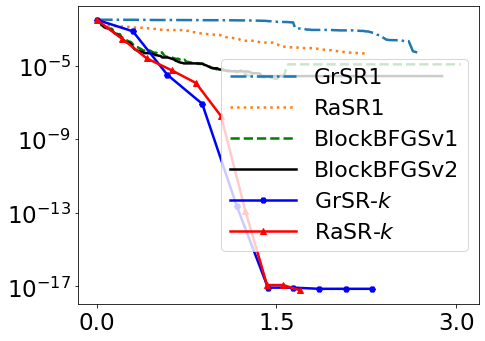

In [ ]:
plt.rcParams['figure.figsize'] = (7, 5) #graph-size
params = {'legend.fontsize': 22,
          'legend.handlelength': 3} #legend-size
plt.rcParams.update(params)
plt.plot(a9a_time_grsr1[:110],a9a_res_grsr1[:110],'-.',linewidth=2.5,label="GrSR1")
plt.plot(a9a_time_rasr1[:150],a9a_res_rasr1[:150],':',linewidth=2.5,label="RaSR1")
plt.plot(a9a_time_blockbfgsv1[:200],a9a_res_blockbfgsv1[:200],'--g',linewidth=2.5,label="BlockBFGSv1")
plt.plot(a9a_time_blockbfgs[:160],a9a_res_blockbfgs[:160],'-k',linewidth=2.5, label="BlockBFGSv2")
plt.plot(a9a_time_grsrk[:100:10], a9a_res_grsrk[:100:10],'-Hb',linewidth=2.5,label="GrSR-$k$")
plt.plot(a9a_time_rasrk[:100:10],a9a_res_rasrk[:100:10],'-^r',linewidth=2.5,label="RaSR-$k$")


plt.tick_params(labelsize=23) #axis-size
plt.legend(loc="center right") #legend-loc
plt.yscale("log")

plt.yticks([1e-17,1e-13,1e-9,1e-5])
plt.xticks([0,1.5,3])
plt.tight_layout()
plt.savefig('blockquasiimg/a9a.time.png')
plt.savefig('blockquasiimg/a9a.time.pdf',format='pdf')

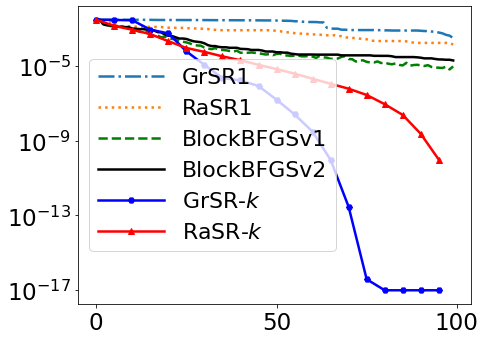

In [ ]:
plt.rcParams['figure.figsize'] = (7, 5) #graph-size
params = {'legend.fontsize': 22,
          'legend.handlelength': 3} #legend-size
plt.rcParams.update(params)
plt.plot(a9a_res_grsr1[:100],'-.',linewidth=2.5,label="GrSR1")
plt.plot(a9a_res_rasr1[:100],':',linewidth=2.5,label="RaSR1")
plt.plot(a9a_res_blockbfgsv1_5[:100],'--g',linewidth=2.5,label="BlockBFGSv1")
plt.plot(a9a_res_blockbfgs_5[:100],'-k',linewidth=2.5, label="BlockBFGSv2")
plt.plot(np.arange(0, 100, 5), a9a_res_grsrk_5[:100:5],'-Hb',linewidth=2.5,label="GrSR-$k$")
plt.plot(np.arange(0, 100, 5),a9a_res_rasrk_5[:100:5],'-^r',linewidth=2.5,label="RaSR-$k$")


plt.tick_params(labelsize=23) #axis-size
plt.legend(loc="center left") #legend-loc
plt.yscale("log")

plt.yticks([1e-17,1e-13,1e-9,1e-5])
plt.xticks([0,50,100])
plt.tight_layout()
plt.savefig('blockquasiimg/a9a.res_5.png')
plt.savefig('blockquasiimg/a9a.res_5.pdf',format='pdf')

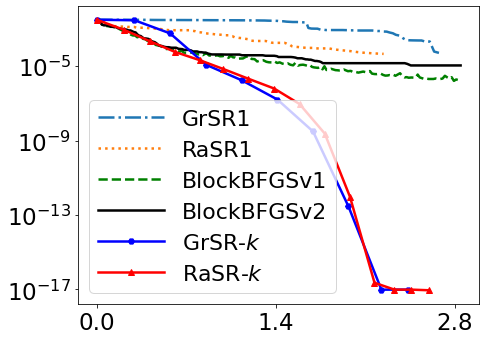

In [ ]:
plt.rcParams['figure.figsize'] = (7, 5) #graph-size
params = {'legend.fontsize': 22,
          'legend.handlelength': 3} #legend-size
plt.rcParams.update(params)
plt.plot(a9a_time_grsr1[:110],a9a_res_grsr1[:110],'-.',linewidth=2.5,label="GrSR1")
plt.plot(a9a_time_rasr1[:150],a9a_res_rasr1[:150],':',linewidth=2.5,label="RaSR1")
plt.plot(a9a_time_blockbfgsv1_5[:160],a9a_res_blockbfgsv1_5[:160],'--g',linewidth=2.5,label="BlockBFGSv1")
plt.plot(a9a_time_blockbfgs_5[:160],a9a_res_blockbfgs_5[:160],'-k',linewidth=2.5, label="BlockBFGSv2")
plt.plot(a9a_time_grsrk_5[:100:10], a9a_res_grsrk_5[:100:10],'-Hb',linewidth=2.5,label="GrSR-$k$")
plt.plot(a9a_time_rasrk_5[:150:10],a9a_res_rasrk_5[:150:10],'-^r',linewidth=2.5,label="RaSR-$k$")


plt.tick_params(labelsize=23) #axis-size
plt.legend(loc="lower left") #legend-loc
plt.yscale("log")

plt.yticks([1e-17,1e-13,1e-9,1e-5])
plt.xticks([0,1.4,2.8])
plt.tight_layout()
plt.savefig('blockquasiimg/a9a.time_5.png')
plt.savefig('blockquasiimg/a9a.time_5.pdf',format='pdf')

# mushroom

In [14]:
filename="mushrooms.txt"
Sparse=sklearn.datasets.load_svmlight_file(filename)[0]
target=sklearn.datasets.load_svmlight_file(filename)[1]
A0=Sparse.toarray().astype("float")
b1=target.reshape([np.shape(target)[0],1]).astype("float")
b1=2*b1-3
oracle=Logistic1(A0,b1,0.00001)
d=A0.shape[1]

FileNotFoundError: [Errno 2] No such file or directory: 'mushrooms.txt'

In [ ]:
x0=np.zeros([oracle.d,1])

In [ ]:
res,x1=Newton(x0,2)

In [ ]:
mush_res_rasrk,mush_time_rasrk=rasrk_sol(x1.copy(),100,20,10,500,True)

0.04721918455543577
6.47880981004768e-08
4.285517343666494e-19
4.285517343666494e-19
4.285517343666494e-19
4.285517343666494e-19
4.285517343666494e-19
4.285517343666494e-19
4.285517343666494e-19
4.285517343666494e-19
4.285517343666494e-19


In [ ]:
mush_res_rasrk_5,mush_time_rasrk_5=rasrk_sol(x1.copy(),100,20,5,500,True)

0.04721918455543577
0.0001103563499253734
2.2239253016060336e-09
7.896182845085768e-19
5.094881247602912e-19
5.094881247602912e-19
5.094881247602912e-19
5.094881247602912e-19
5.094881247602912e-19
5.094881247602912e-19
5.094881247602912e-19


In [ ]:

mush_res_rasr1,mush_time_rasr1=rasrk_sol(x1.copy(),10,20,1,500,True)

0.04689250365697619
0.008483011162323573
0.0017427429241966416
0.00047104974011264345
0.00017172359676078378
7.635032116636721e-05
3.291771008725969e-05
5.170496930650228e-06
1.9909235661506668e-08
5.934365323114083e-16
3.5654511864080587e-19


In [ ]:
mush_res_grsrk,mush_time_grsrk=grsrk_sol(x1.copy(),100,20,10,500,True)

0.04721918455543577
2.051132033526958e-07
1.3991434969816382e-18
4.379035971984867e-19
4.379035971984867e-19
4.379035971984867e-19
4.379035971984867e-19
4.379035971984867e-19
4.379035971984867e-19
4.379035971984867e-19
4.379035971984867e-19


In [ ]:
mush_res_grsrk_5,mush_time_grsrk_5=grsrk_sol(x1.copy(),10,20,5,500,True)

0.04689250365697619
8.32938240951695e-05
2.2943759894098134e-08
1.1535844625959004e-17
1.1535844625959004e-17
1.1535844625959004e-17
1.1535844625959004e-17
1.1535844625959004e-17
1.1535844625959004e-17
1.1535844625959004e-17
1.1535844625959004e-17


In [ ]:
mush_res_grsr1,mush_time_grsr1=grsrk_sol(x1.copy(),10,20,1,500,True)

0.04689250365697619
0.03999369678939236
0.0016998520010943028
0.0007128429494187878
0.00014445732550726358
1.54428056269365e-05
4.355345474437172e-07
1.1702045921201019e-16
4.959805004568622e-19
4.624112000781231e-19
4.624112000781231e-19


In [ ]:
mush_res_blockbfgs,mush_time_blockbfgs=BlockBFGS(x1.copy(),10,2,10,500,True)

0.04689250365697619
7.233062271099306e-08
6.454515757831859e-19
6.454515757831859e-19
6.454515757831859e-19
6.454515757831859e-19
6.454515757831859e-19
6.454515757831859e-19
6.454515757831859e-19
6.454515757831859e-19
6.454515757831859e-19


In [ ]:
mush_res_blockbfgs_5,mush_time_blockbfgs_5=BlockBFGS(x1.copy(),10,2,5,500,True)

0.04689250365697619
5.77474230810003e-05
7.81458338630601e-09
1.301228083991728e-18
5.598211714350761e-19
5.598211714350761e-19
5.598211714350761e-19
5.598211714350761e-19
5.598211714350761e-19
5.598211714350761e-19
5.598211714350761e-19


In [ ]:
mush_res_blockbfgsv1,mush_time_blockbfgsv1=BlockBFGSv1(x1.copy(),1000,10,500)

0.047252020404029094
7.500801293164898e-07
4.126656786168832e-12
4.126656786168832e-12
4.126656786168832e-12
4.126656786168832e-12
4.126656786168832e-12
4.126656786168832e-12
4.126656786168832e-12
4.126656786168832e-12
4.126656786168832e-12


In [ ]:
mush_res_blockbfgsv1_5,mush_time_blockbfgsv1_5=BlockBFGSv1(x1.copy(),1000,5,500)

0.047252020404029094
5.6962516808795216e-05
1.3771777051001696e-08
1.0640509745386823e-12
1.0640509745386823e-12
1.0640509745386823e-12
1.0640509745386823e-12
1.0640509745386823e-12
1.0640509745386823e-12
1.0640509745386823e-12
1.0640509745386823e-12


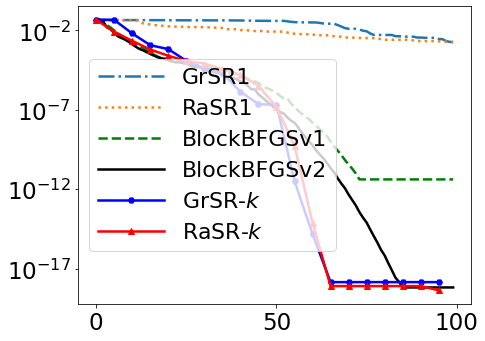

In [ ]:
plt.rcParams['figure.figsize'] = (7, 5) #graph-size
params = {'legend.fontsize': 22,
          'legend.handlelength': 3} #legend-size
plt.rcParams.update(params)
plt.plot(mush_res_grsr1[:100],'-.',linewidth=2.5,label="GrSR1")
plt.plot(mush_res_rasr1[:100],':',linewidth=2.5,label="RaSR1")
plt.plot(mush_res_blockbfgsv1[:100],'--g',linewidth=2.5,label="BlockBFGSv1")
plt.plot(mush_res_blockbfgs[:100],'-k',linewidth=2.5, label="BlockBFGSv2")
plt.plot(np.arange(0, 100, 5), mush_res_grsrk[:100:5],'-Hb',linewidth=2.5,label="GrSR-$k$")
plt.plot(np.arange(0, 100, 5),mush_res_rasrk[:100:5],'-^r',linewidth=2.5,label="RaSR-$k$")


plt.tick_params(labelsize=23) #axis-size
plt.legend(loc="center left") #legend-loc
plt.yscale("log")

plt.yticks([1e-17,1e-12,1e-7,1e-2])
plt.xticks([0,50,100])
plt.tight_layout()
plt.savefig('blockquasiimg/mushroom.res.png')
plt.savefig('blockquasiimg/mushroom.res.pdf',format='pdf')

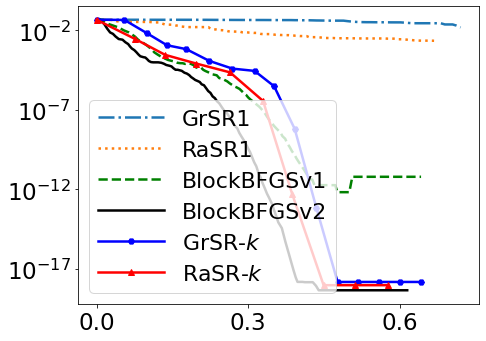

In [ ]:
plt.rcParams['figure.figsize'] = (7, 5) #graph-size
params = {'legend.fontsize': 22,
          'legend.handlelength': 3} #legend-size
plt.rcParams.update(params)
plt.plot(mush_time_grsr1[:80],mush_res_grsr1[:80],'-.',linewidth=2.5,label="GrSR1")
plt.plot(mush_time_rasr1[:120],mush_res_rasr1[:120],':',linewidth=2.5,label="RaSR1")
plt.plot(mush_time_blockbfgsv1[:120],mush_res_blockbfgsv1[:120],'--g',linewidth=2.5,label="BlockBFGSv1")
plt.plot(mush_time_blockbfgs[:120],mush_res_blockbfgs[:120],'-k',linewidth=2.5, label="BlockBFGSv2")
plt.plot(mush_time_grsrk[:80:5],mush_res_grsrk[:80:5],'-Hb',linewidth=2.5,label="GrSR-$k$")
plt.plot(mush_time_rasrk[:100:10],mush_res_rasrk[:100:10],'-^r',linewidth=2.5,label="RaSR-$k$")


plt.tick_params(labelsize=23) #axis-size
plt.legend(loc="lower left") #legend-loc
plt.yscale("log")

plt.yticks([1e-17,1e-12,1e-7,1e-2])
plt.xticks([0,0.3,.6])
plt.tight_layout()
plt.savefig('blockquasiimg/mushroom.time.png')
plt.savefig('blockquasiimg/mushroom.time.pdf',format='pdf')

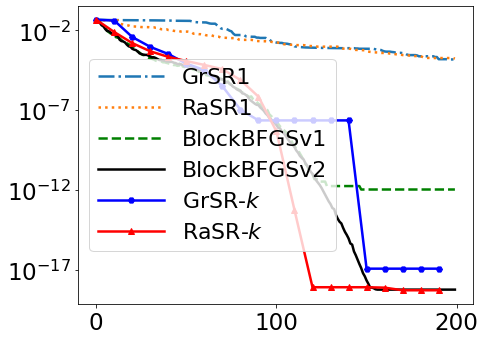

In [ ]:
plt.rcParams['figure.figsize'] = (7, 5) #graph-size
params = {'legend.fontsize': 22,
          'legend.handlelength': 3} #legend-size
plt.rcParams.update(params)
plt.plot(mush_res_grsr1[:200],'-.',linewidth=2.5,label="GrSR1")
plt.plot(mush_res_rasr1[:200],':',linewidth=2.5,label="RaSR1")
plt.plot(mush_res_blockbfgsv1_5[:200],'--g',linewidth=2.5,label="BlockBFGSv1")
plt.plot(mush_res_blockbfgs_5[:200],'-k',linewidth=2.5, label="BlockBFGSv2")
plt.plot(np.arange(0, 200, 10), mush_res_grsrk_5[:200:10],'-Hb',linewidth=2.5,label="GrSR-$k$")
plt.plot(np.arange(0, 200,10),mush_res_rasrk_5[:200:10],'-^r',linewidth=2.5,label="RaSR-$k$")


plt.tick_params(labelsize=23) #axis-size
plt.legend(loc="center left") #legend-loc
plt.yscale("log")

plt.yticks([1e-17,1e-12,1e-7,1e-2])
plt.xticks([0,100,200])
plt.tight_layout()
plt.savefig('blockquasiimg/mushroom.res_5.png')
plt.savefig('blockquasiimg/mushroom.res_5.pdf',format='pdf')

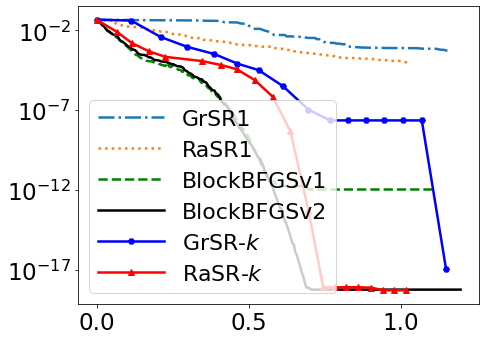

In [ ]:
plt.rcParams['figure.figsize'] = (7, 5) #graph-size
params = {'legend.fontsize': 22,
          'legend.handlelength': 3} #legend-size
plt.rcParams.update(params)
plt.plot(mush_time_grsr1[:160],mush_res_grsr1[:160],'-.',linewidth=2.5,label="GrSR1")
plt.plot(mush_time_rasr1[:240],mush_res_rasr1[:240],':',linewidth=2.5,label="RaSR1")
plt.plot(mush_time_blockbfgsv1_5[:240],mush_res_blockbfgsv1_5[:240],'--g',linewidth=2.5,label="BlockBFGSv1")
plt.plot(mush_time_blockbfgs_5[:240],mush_res_blockbfgs_5[:240],'-k',linewidth=2.5, label="BlockBFGSv2")
plt.plot(mush_time_grsrk_5[:160:10],mush_res_grsrk_5[:160:10],'-Hb',linewidth=2.5,label="GrSR-$k$")
plt.plot(mush_time_rasrk_5[:200:10],mush_res_rasrk_5[:200:10],'-^r',linewidth=2.5,label="RaSR-$k$")


plt.tick_params(labelsize=23) #axis-size
plt.legend(loc="lower left") #legend-loc
plt.yscale("log")

plt.yticks([1e-17,1e-12,1e-7,1e-2])
plt.xticks([0,0.5,1.0])
plt.tight_layout()
plt.savefig('blockquasiimg/mushroom.time_5.png')
plt.savefig('blockquasiimg/mushroom.time_5.pdf',format='pdf')

# medelon

In [ ]:
filename="madelon.txt"
Sparse=sklearn.datasets.load_svmlight_file(filename)[0]
target=sklearn.datasets.load_svmlight_file(filename)[1]
A0=Sparse.toarray().astype("float")
b1=target.reshape([np.shape(target)[0],1]).astype("float")
oracle=Logistic1(A0,b1,0.00001)
d=A0.shape[1]

In [ ]:
x0=np.zeros([oracle.d,1])

In [ ]:
np.shape(oracle.X)

(2000, 500)

In [ ]:
res,x1=Newton(x0,4)

In [ ]:
res[-1]

0.0004197584777659057

In [ ]:
made_res_rasrk_50,made_time_rasrk_50=rasrk_sol(x1.copy(),10000,2,60,150,True)

0.0004197584777659057
6.883616191308866e-08
1.8300920834711827e-13
1.8300920834711827e-13
1.8300920834711827e-13
1.8300920834711827e-13
1.8300920834711827e-13
1.8300920834711827e-13
1.8300920834711827e-13
1.8300920834711827e-13
1.8300920834711827e-13
1.8300920834711827e-13
1.8300920834711827e-13
1.8300920834711827e-13
1.8300920834711827e-13
1.8300920834711827e-13


In [ ]:
made_res_rasrk_100,made_time_rasrk_100=rasrk_sol(x1.copy(),10000,2,200,150,True)

0.0004197584777659057
2.34470171875164e-12
7.618324029758419e-13
7.618324029758419e-13
7.618324029758419e-13
7.618324029758419e-13
7.618324029758419e-13
7.618324029758419e-13
7.618324029758419e-13
7.618324029758419e-13
7.618324029758419e-13
7.618324029758419e-13
7.618324029758419e-13
7.618324029758419e-13
7.618324029758419e-13
7.618324029758419e-13


/var/folders/xj/3ycpd85n3tv5xc1s912lypww0000gn/T/ipykernel_35394/89642001.py:5: UserWarning: Attempted to set non-positive bottom ylim on a log-scaled axis.
Invalid limit will be ignored.
  plt.ylim([10-12,1])


(6.229405696599264e-14, 1)

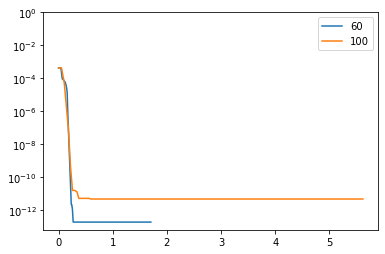

In [ ]:
plt.plot(made_time_rasrk_50,made_res_rasrk_50,label='60')
plt.plot(made_time_rasrk_100,made_res_rasrk_100,label='100')
plt.yscale('log')
plt.legend()
plt.ylim([10-12,1])

In [ ]:
made_res_rasrk,made_time_rasrk=rasrk_sol(x1.copy(),10000,2,10,500,True)

0.6962007005144604
7.907971325651245e-05
5.9920916625490336e-05
4.6540898674225495e-05
3.005944597540235e-05
1.1038383138436049e-05
4.105922251977626e-08
3.078414159010001e-11
6.11819924488265e-12
5.563600676628532e-12
2.7124334560831363e-11
1499.1964563107197
6020.868062751498
6352.2339199545095
6805.95471798393
6978.115856110325
7024.130481662711
6902.107538941938
6737.008009275507
6537.970487164735
6933.944757247685
7078.93417855675
4410.107042349579
6833.072081636267
6959.230735345991
7210.622281895077
7138.339894498197
7389.929169686542
7445.579546459703
7470.0664608536845
5079.132579509328
7385.518099614607
7533.906955685933
7419.548489108716
7410.946668295983
6774.249944356669
7303.134744436444
6064.821397849966
7358.579060412524
4997.780693592727
7477.2582217691015
6979.372975515694
7459.1529142584095
7398.990347375009
7510.548107330741
7484.822912294919
7409.087609260817
7401.070418670288
6799.477542987915
7379.600052980038
6766.122178762573


In [ ]:
made_res_rasrk_5,made_time_rasrk_5=rasrk_sol(x1.copy(),10000,2,5,500,True)

0.6962007005144604
8.22232991663747e-05
6.83929291567849e-05
5.868216012780457e-05
5.153555456118386e-05
4.596441389526509e-05
3.954735135892864e-05
3.382540064550177e-05
3.0577027549082545e-05
2.028710778805549e-05
5.65646965592051e-06
8.432366731883168e-07
5.640797817461741e-08
1.3255399798129524e-10
6.468334958749768e-13
8.239071831557122e-12
1.4996475025299672e-12
3.519445912005947e-11
3.516262562361859e-11
2.9766491990066116e-12
3.694224795711832e-12
0.013037881571822526
9.007426960784107
124.88213896065129
31.394532717046346
9.185152743532328
63.65965917105898
8.437636327403483
19.203429255819593
27.67229506607327
602.2717682718342
359.5055373820322
41.95317664628218
187.72806618876467
364.2444527351334
5514.840371279059
5734.045520548055
2446.392783535875
4699.758079551216
5309.553949848854
6048.531235158095
6066.699116023914
6357.178505496992
4561.222751787588
5423.671946167973
4284.326010159181
6594.380864742839
6521.490910471479
6695.569020785297
6716.270013434975
6857.127997

In [ ]:
made_res_rasr1,made_time_rasr1=rasrk_sol(x1.copy(),1000,2,1,500,True)

0.0004197584777659057
0.0004015400916653011
0.00026932713027959585
0.00025704106505421414
0.0002173181821112935
0.00011713826259877114
4.233831939333786e-05
2.0525273461154543e-05
1.3729642260268042e-05
9.44279742516547e-06
4.907735654111265e-06


In [ ]:
made_res_grsrk,made_time_grsrk=grsrk_sol(x1.copy(),10000,1,10,500,True)

0.0004197584777659057
5.099365278822755e-07
4.793536255427847e-12
4.793536255427847e-12
4.793536255427847e-12
4.793536255427847e-12
4.793536255427847e-12
4.793536255427847e-12
4.793536255427847e-12
4.793536255427847e-12
4.793536255427847e-12


In [ ]:
made_res_grsrk_5,made_time_grsrk_5=grsrk_sol(x1.copy(),10000,1,5,500,True)

0.0004197584777659057
8.24891139337217e-05
4.239147948795038e-07
1.4820165148487008e-12
1.4820165148487008e-12
1.4820165148487008e-12
1.4820165148487008e-12
1.4820165148487008e-12
1.4820165148487008e-12
1.4820165148487008e-12
1.4820165148487008e-12


In [ ]:
made_res_grsr1,made_time_grsr1=grsrk_sol(x1.copy(),10000,10,1,500,True)

0.0004197584777659057
5.443646032385587e-05
5.1275414962631916e-05
5.1275414962631916e-05
5.1275414962631916e-05
5.1275414962631916e-05
5.1275414962631916e-05
5.1275414962631916e-05
5.1275414962631916e-05
5.1275414962631916e-05
5.946615926033022e-06


In [ ]:
made_res_blockbfgs, made_time_blockbfgs = BlockBFGS(x1.copy(),10000,1,10,500,True)

0.0004197584777659057
3.530905065445542e-05
3.343996067447119e-05
3.343996067447119e-05
3.343996067447119e-05
3.343996067447119e-05
3.343996067447119e-05
3.343996067447119e-05
3.343996067447119e-05
3.343996067447119e-05
3.343996067447119e-05


In [ ]:
made_res_blockbfgs_5, made_time_blockbfgs_5 = BlockBFGS(x1.copy(),10000,10,5,500,True)

0.0004197584777659057
6.762621866036731e-05
4.23949488874854e-05
4.23949488874854e-05
4.23949488874854e-05
4.23949488874854e-05
4.23949488874854e-05
4.23949488874854e-05
4.23949488874854e-05
4.23949488874854e-05
4.23949488874854e-05


In [ ]:
made_res_blockbfgsv1, made_time_blockbfgsv1 = BlockBFGSv1(x1.copy(),10000,10,500)

0.0004197584777659057
3.3545417273133294e-05
0.004596043463379307
0.004596043463379307
0.004596043463379307
0.004596043463379307
0.004596043463379307
0.004596043463379307
0.004596043463379307
0.004596043463379307
0.004596043463379307


In [ ]:
made_res_blockbfgsv1_5, made_time_blockbfgsv1_5 = BlockBFGSv1(x1.copy(),10000,5,500)

0.0004197584777659057
5.41650144482548e-05
0.0009562443086969228
0.0009562443086969228
0.0009562443086969228
0.0009562443086969228
0.0009562443086969228
0.0009562443086969228
0.0009562443086969228
0.0009562443086969228
0.0009562443086969228


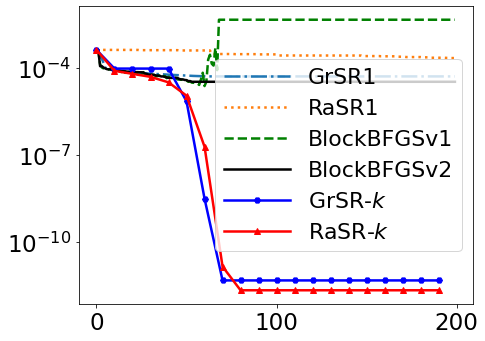

In [ ]:
plt.rcParams['figure.figsize'] = (7, 5) #graph-size
params = {'legend.fontsize': 22,
          'legend.handlelength': 3} #legend-size
plt.rcParams.update(params)
plt.plot(made_res_grsr1[:200],'-.',linewidth=2.5,label="GrSR1")
plt.plot(made_res_rasr1[:200],':',linewidth=2.5,label="RaSR1")
plt.plot(made_res_blockbfgsv1[:200],'--g',linewidth=2.5,label="BlockBFGSv1")
plt.plot(made_res_blockbfgs[:200],'-k',linewidth=2.5, label="BlockBFGSv2")
plt.plot(np.arange(0, 200, 10), made_res_grsrk[:200:10],'-Hb',linewidth=2.5,label="GrSR-$k$")
plt.plot(np.arange(0, 200, 10),made_res_rasrk[:200:10],'-^r',linewidth=2.5,label="RaSR-$k$")



plt.tick_params(labelsize=23) #axis-size
plt.legend(loc="center right") #legend-loc
plt.yscale("log")

plt.yticks([1e-10,1e-7,1e-4])
plt.xticks([0,100,200])
plt.tight_layout()
plt.savefig('blockquasiimg/made.res.png')
plt.savefig('blockquasiimg/made.res.pdf',format='pdf')

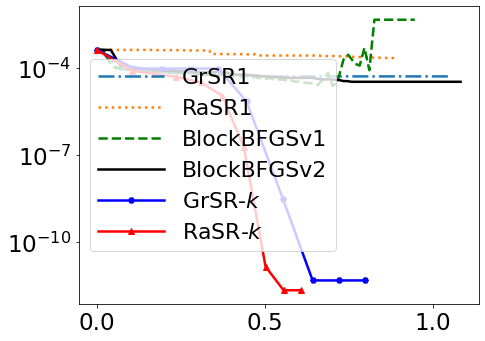

In [ ]:
plt.rcParams['figure.figsize'] = (7, 5) #graph-size
params = {'legend.fontsize': 22,
          'legend.handlelength': 3} #legend-size
plt.rcParams.update(params)
plt.plot(made_time_grsr1[:140],made_res_grsr1[:140],'-.',linewidth=2.5,label="GrSR1")
plt.plot(made_time_rasr1[:200],made_res_rasr1[:200],':',linewidth=2.5,label="RaSR1")
plt.plot(made_time_blockbfgsv1[:80],made_res_blockbfgsv1[:80],'--g',linewidth=2.5,label="BlockBFGSv1")
plt.plot(made_time_blockbfgs[:80],made_res_blockbfgs[:80],'-k',linewidth=2.5, label="BlockBFGSv2")
plt.plot(made_time_grsrk[:100:10], made_res_grsrk[:100:10],'-Hb',linewidth=2.5,label="GrSR-$k$")
plt.plot(made_time_rasrk[:100:10],made_res_rasrk[:100:10],'-^r',linewidth=2.5,label="RaSR-$k$")


plt.tick_params(labelsize=23) #axis-size
plt.legend(loc="center left") #legend-loc
plt.yscale("log")

plt.yticks([1e-10,1e-7,1e-4])
plt.xticks([0,0.5,1])
plt.tight_layout()
plt.savefig('blockquasiimg/made.time.png')
plt.savefig('blockquasiimg/made.time.pdf',format='pdf')

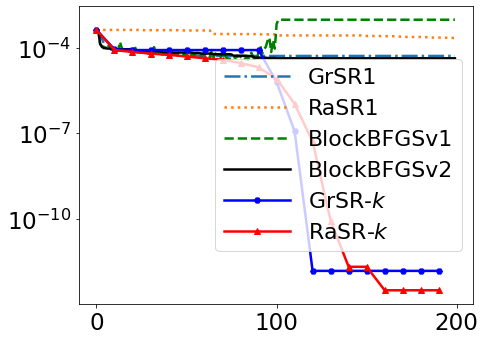

In [ ]:
plt.rcParams['figure.figsize'] = (7, 5) #graph-size
params = {'legend.fontsize': 22,
          'legend.handlelength': 3} #legend-size
plt.rcParams.update(params)
plt.plot(made_res_grsr1[:200],'-.',linewidth=2.5,label="GrSR1")
plt.plot(made_res_rasr1[:200],':',linewidth=2.5,label="RaSR1")
plt.plot(made_res_blockbfgsv1_5[:200],'--g',linewidth=2.5,label="BlockBFGSv1")
plt.plot(made_res_blockbfgs_5[:200],'-k',linewidth=2.5, label="BlockBFGSv2")
plt.plot(np.arange(0, 200, 10), made_res_grsrk_5[:200:10],'-Hb',linewidth=2.5,label="GrSR-$k$")
plt.plot(np.arange(0, 200, 10),made_res_rasrk_5[:200:10],'-^r',linewidth=2.5,label="RaSR-$k$")



plt.tick_params(labelsize=23) #axis-size
plt.legend(loc="center right") #legend-loc
plt.yscale("log")

plt.yticks([1e-10,1e-7,1e-4])
plt.xticks([0,100,200])
plt.tight_layout()
plt.savefig('blockquasiimg/made.res_5.png')
plt.savefig('blockquasiimg/made.res_5.pdf',format='pdf')

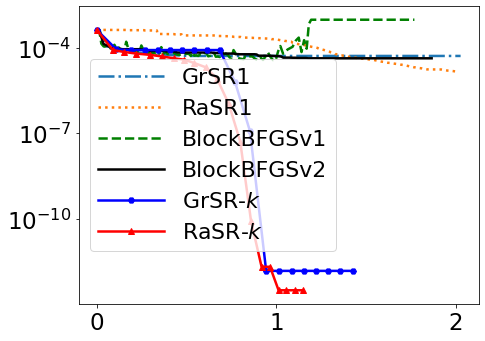

In [ ]:
plt.rcParams['figure.figsize'] = (7, 5) #graph-size
params = {'legend.fontsize': 22,
          'legend.handlelength': 3} #legend-size
plt.rcParams.update(params)
plt.plot(made_time_grsr1[:300],made_res_grsr1[:300],'-.',linewidth=2.5,label="GrSR1")
plt.plot(made_time_rasr1[:400],made_res_rasr1[:400],':',linewidth=2.5,label="RaSR1")
plt.plot(made_time_blockbfgsv1_5[:160],made_res_blockbfgsv1_5[:160],'--g',linewidth=2.5,label="BlockBFGSv1")
plt.plot(made_time_blockbfgs_5[:160],made_res_blockbfgs_5[:160],'-k',linewidth=2.5, label="BlockBFGSv2")
plt.plot(made_time_grsrk_5[:200:10], made_res_grsrk_5[:200:10],'-Hb',linewidth=2.5,label="GrSR-$k$")
plt.plot(made_time_rasrk_5[:200:10],made_res_rasrk_5[:200:10],'-^r',linewidth=2.5,label="RaSR-$k$")


plt.tick_params(labelsize=23) #axis-size
plt.legend(loc="center left") #legend-loc
plt.yscale("log")

plt.yticks([1e-10,1e-7,1e-4])
plt.xticks([0,1,2])
plt.tight_layout()
plt.savefig('blockquasiimg/made.time_5.png')
plt.savefig('blockquasiimg/made.time_5.pdf',format='pdf')

In [ ]:
made_res_grsr_1,made_time_grsr_1=grsrk_sol(x1.copy(),1000,20,1,500,True)

0.0004197584777659057
0.0004197584777659057
0.0004197584777659057
0.0004197584777659057
0.0004197584777659057
0.0004197584777659057
0.0004197584777659057
0.0004197584777659057
0.0004197584777659057
0.0004197584777659057
8.706357992335253e-06


In [ ]:
made_res_grsr_2,made_time_grsr_2=grsrk_sol(x1.copy(),10000,2,2,500,True)

0.0004197584777659057
6.393653913235278e-05
6.393653913235278e-05
6.393653913235278e-05
6.393653913235278e-05
1.6078115804844581e-06
2.5010341597724086e-12
3.9335865853914877e-13
3.9335865853914877e-13
3.9335865853914877e-13
3.564948236184776e-13


In [ ]:
made_res_grsr_5,made_time_grsr_5=grsrk_sol(x1.copy(),10000,2,5,500,True)

0.0004197584777659057
8.252575231195645e-05
4.2273661134374416e-07
7.961568341453621e-13
2.1090973182449325e-13
2.1090973182449325e-13
2.1090973182449325e-13
2.1090973182449325e-13
2.1090973182449325e-13
2.1090973182449325e-13
2.1090973182449325e-13


In [ ]:
made_res_grsr_10,made_time_grsr_10=grsrk_sol(x1.copy(),10000,2,10,500,True)

0.0004197584777659057
5.541599373009139e-07
3.3137147728316554e-12
3.3137147728316554e-12
3.3137147728316554e-12
3.3137147728316554e-12
3.3137147728316554e-12
3.3137147728316554e-12
3.3137147728316554e-12
3.3137147728316554e-12
3.3137147728316554e-12


In [ ]:
made_res_grsr_20,made_time_grsr_20=grsrk_sol(x1.copy(),100000,20,20,100,True)

0.0004197584777659057
5.429996059611186e-13
2.2139107981825855e-13


In [ ]:
made_res_grsr_500,made_time_grsr_500=grsrk_sol(x1.copy(),10000,20,500,200,True)

0.0004197584777659057
2.657054999390048e-12
2.657054999390048e-12
2.657054999390048e-12
2.657054999390048e-12


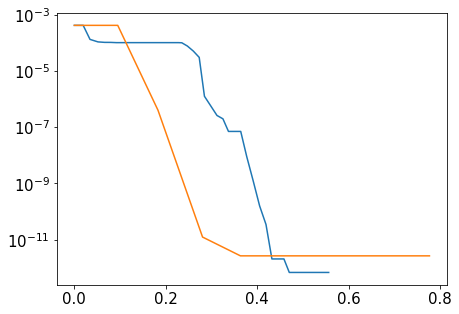

In [ ]:
plt.plot(made_time_grsr_20[:50],made_res_grsr_20[:50])
plt.plot(made_time_grsr_500[:10],made_res_grsr_500[:10])
plt.yscale("log")

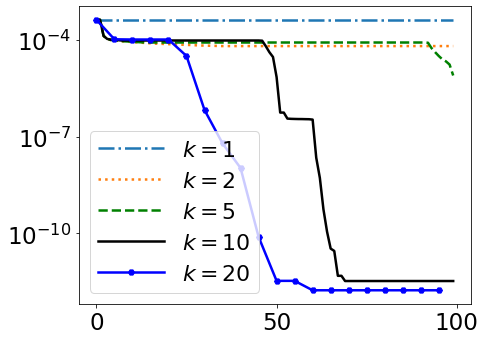

In [ ]:
plt.rcParams['figure.figsize'] = (7, 5) #graph-size
params = {'legend.fontsize': 22,
          'legend.handlelength': 3} #legend-size
plt.rcParams.update(params)
plt.plot(made_res_grsr_1[:100],'-.',linewidth=2.5,label="$k=1$")
plt.plot(made_res_grsr_2[:100],':',linewidth=2.5,label="$k=2$")
plt.plot(made_res_grsr_5[:100],'--g',linewidth=2.5,label="$k=5$")
plt.plot(made_res_grsr_10[:100],'-k',linewidth=2.5, label="$k=10$")
plt.plot(np.arange(0, 100, 5),made_res_grsr_20[:100:5],'-Hb',linewidth=2.5,label="$k=20$")
plt.tick_params(labelsize=23) #axis-size
plt.legend(loc="lower left") #legend-loc
plt.yscale("log")

plt.yticks([1e-10,1e-7,1e-4])
plt.xticks([0,50,100])
plt.tight_layout()
plt.savefig('blockquasiimg/madegr.res.png')
plt.savefig('blockquasiimg/madegr.res.pdf',format='pdf')

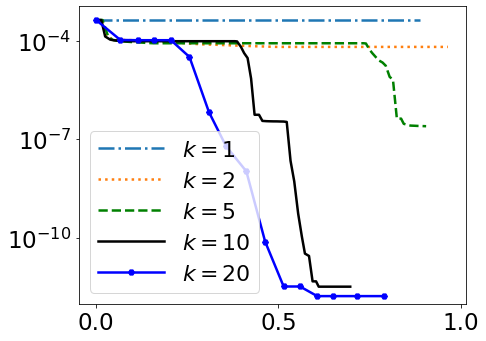

In [ ]:
plt.rcParams['figure.figsize'] = (7, 5) #graph-size
params = {'legend.fontsize': 22,
          'legend.handlelength': 3} #legend-size
plt.rcParams.update(params)
plt.plot(made_time_grsr_1[:130],made_res_grsr_1[:130],'-.',linewidth=2.5,label="$k=1$")
plt.plot(made_time_grsr_2[:100],made_res_grsr_2[:100],':',linewidth=2.5,label="$k=2$")
plt.plot(made_time_grsr_5[:110],made_res_grsr_5[:110],'--g',linewidth=2.5,label="$k=5$")
plt.plot(made_time_grsr_10[:80],made_res_grsr_10[:80],'-k',linewidth=2.5, label="$k=10$")
plt.plot(made_time_grsr_20[:80:5],made_res_grsr_20[:80:5],'-Hb',linewidth=2.5,label="$k=20$")
plt.tick_params(labelsize=23) #axis-size
plt.legend(loc="lower left") #legend-loc
plt.yscale("log")

plt.yticks([1e-10,1e-7,1e-4])
plt.ylim(1e-12)
plt.xticks([0,0.5,1])
plt.tight_layout()
plt.savefig('blockquasiimg/madegr.time.png')
plt.savefig('blockquasiimg/madegr.time.pdf',format='pdf')

In [ ]:
made_res_rasr_1,made_time_rasr_1=rasrk_sol(x1.copy(),1000,2,1,500,True)

0.0004197584777659057
0.00034753926202996213
0.00032528835323827865
0.0003103964059515829
0.00025393393418956324
0.00013202810118736284
8.527706591424978e-05
3.4989545409630464e-05
2.118984797958432e-05
1.4331149927972048e-05
7.670494522881787e-06


In [ ]:
made_res_rasr_2,made_time_rasr_2=rasrk_sol(x1.copy(),1000,2,2,500,True)

0.0004197584777659057
0.0002616185885856033
0.00019565669322739172
4.698740636623979e-05
1.396840816915267e-05
4.371453721109112e-06
1.4001240704415462e-09
1.690454552325945e-12
2.068009994233744e-13
1.7357283406161793e-13
1.7357283406161793e-13


In [ ]:
made_res_rasr_5,made_time_rasr_5=rasrk_sol(x1.copy(),1000,2,5,500,True)

0.0004197584777659057
6.451833329140293e-05
1.0114571177935797e-05
7.616966434379876e-13
7.616966434379876e-13
7.616966434379876e-13
7.616966434379876e-13
7.616966434379876e-13
7.616966434379876e-13
7.616966434379876e-13
7.616966434379876e-13


In [ ]:
made_res_rasr_10,made_time_rasr_10=rasrk_sol(x1.copy(),10000,2,10,500,True)

0.0004197584777659057
7.673845166464486e-06
3.754694394946443e-13
3.754694394946443e-13
3.754694394946443e-13
3.754694394946443e-13
3.754694394946443e-13
3.754694394946443e-13
3.754694394946443e-13
3.754694394946443e-13
3.754694394946443e-13


In [ ]:
made_res_rasr_20,made_time_rasr_20=rasrk_sol(x1.copy(),10000,2,20,500,True)

0.0004197584777659057
1.6406462482982606e-12
1.6406462482982606e-12
1.6406462482982606e-12
1.6406462482982606e-12
1.6406462482982606e-12
1.6406462482982606e-12
1.6406462482982606e-12
1.6406462482982606e-12
1.6406462482982606e-12
1.6406462482982606e-12


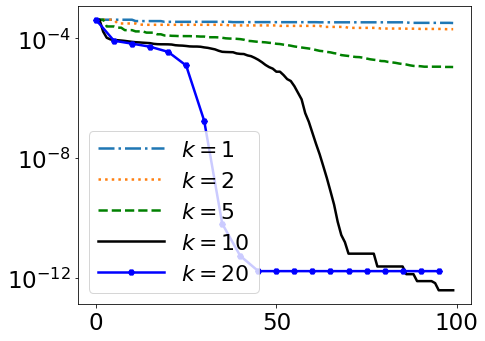

In [ ]:
plt.rcParams['figure.figsize'] = (7, 5) #graph-size
params = {'legend.fontsize': 22,
          'legend.handlelength': 3} #legend-size
plt.rcParams.update(params)
plt.plot(made_res_rasr_1[:100],'-.',linewidth=2.5,label="$k=1$")
plt.plot(made_res_rasr_2[:100],':',linewidth=2.5,label="$k=2$")
plt.plot(made_res_rasr_5[:100],'--g',linewidth=2.5,label="$k=5$")
plt.plot(made_res_rasr_10[:100],'-k',linewidth=2.5, label="$k=10$")
plt.plot(np.arange(0, 100, 5),made_res_rasr_20[:100:5],'-Hb',linewidth=2.5,label="$k=20$")
plt.tick_params(labelsize=23) #axis-size
plt.legend(loc="lower left") #legend-loc
plt.yscale("log")

plt.yticks([1e-12,1e-8,1e-4])
plt.xticks([0,50,100])
plt.tight_layout()
plt.savefig('blockquasiimg/madera.res.png')
plt.savefig('blockquasiimg/madera.res.pdf',format='pdf')

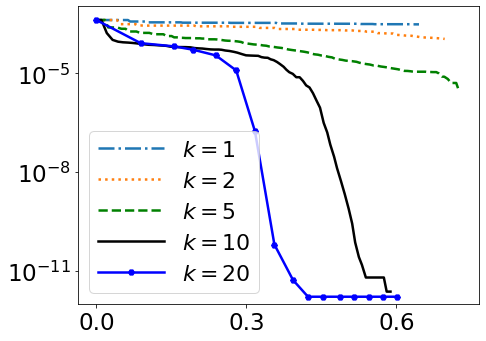

In [ ]:
plt.rcParams['figure.figsize'] = (7, 5) #raaph-size
params = {'legend.fontsize': 22,
          'legend.handlelength': 3} #legend-size
plt.rcParams.update(params)
plt.plot(made_time_rasr_1[:150],made_res_rasr_1[:150],'-.',linewidth=2.5,label="$k=1$")
plt.plot(made_time_rasr_2[:130],made_res_rasr_2[:130],':',linewidth=2.5,label="$k=2$")
plt.plot(made_time_rasr_5[:110],made_res_rasr_5[:110],'--g',linewidth=2.5,label="$k=5$")
plt.plot(made_time_rasr_10[:80],made_res_rasr_10[:80],'-k',linewidth=2.5, label="$k=10$")
plt.plot(made_time_rasr_20[:80:5],made_res_rasr_20[:80:5],'-Hb',linewidth=2.5,label="$k=20$")
plt.tick_params(labelsize=23) #axis-size
plt.legend(loc="lower left") #legend-loc
plt.yscale("log")

plt.yticks([1e-11,1e-8,1e-5])
plt.ylim(1e-12)
plt.xticks([0,0.3,0.6])
plt.tight_layout()
plt.savefig('blockquasiimg/madera.time.png')
plt.savefig('blockquasiimg/madera.time.pdf',format='pdf')

# With Different $k$ (mushroom)

In [ ]:
mush_res_grsr_1,mush_time_grsr_1=grsrk_sol(x1.copy(),10,20,1,500,True)

0.04689250365697619
0.03999369678939236
0.0016998520010943028
0.0007128429494187878
0.00014445732550726358
1.54428056269365e-05
4.355345474437172e-07
1.1702045921201019e-16
4.959805004568622e-19
4.624112000781231e-19
4.624112000781231e-19


In [ ]:
mush_res_grsr_2,mush_time_grsr_2=grsrk_sol(x1.copy(),10,20,2,500,True)

0.04689250365697619
0.001425686250214041
0.00016633259729734935
1.4347141362412956e-06
4.2124687860335287e-19
4.2124687860335287e-19
4.2124687860335287e-19
4.2124687860335287e-19
4.2124687860335287e-19
4.2124687860335287e-19
4.2124687860335287e-19


In [ ]:
mush_res_grsr_5,mush_time_grsr_5=grsrk_sol(x1.copy(),500,20,5,500,True)

0.04724837046894342
7.923932280251847e-05
6.644095637841549e-19
6.644095637841549e-19
6.644095637841549e-19
6.644095637841549e-19
6.644095637841549e-19
6.644095637841549e-19
6.644095637841549e-19
6.644095637841549e-19
6.644095637841549e-19


In [ ]:

mush_res_grsr_10,mush_time_grsr_10=grsrk_sol(x1.copy(),100,20,10,500,True)

0.04721918455543577
2.051132033526958e-07
1.3991434969816382e-18
4.379035971984867e-19
4.379035971984867e-19
4.379035971984867e-19
4.379035971984867e-19
4.379035971984867e-19
4.379035971984867e-19
4.379035971984867e-19
4.379035971984867e-19


In [ ]:
mush_res_grsr_20,mush_time_grsr_20=grsrk_sol(x1.copy(),500,10,20,500,True)

0.04724837046894342
6.290435935864904e-19
6.290435935864904e-19
6.290435935864904e-19
6.290435935864904e-19
6.290435935864904e-19
6.290435935864904e-19
6.290435935864904e-19
6.290435935864904e-19
6.290435935864904e-19
6.290435935864904e-19


In [ ]:
mush_res_grsr_50,mush_time_grsr_50=grsrk_sol(x1.copy(),500,10,50,500,True)

0.04724837046894342
5.574862055596798e-19
5.574862055596798e-19
5.574862055596798e-19
5.574862055596798e-19
5.574862055596798e-19
5.574862055596798e-19
5.574862055596798e-19
5.574862055596798e-19
5.574862055596798e-19
5.574862055596798e-19


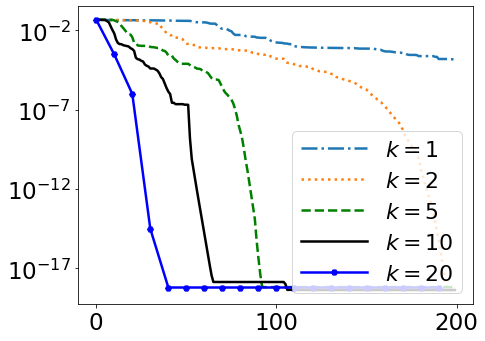

In [ ]:
plt.rcParams['figure.figsize'] = (7, 5) #graph-size
params = {'legend.fontsize': 22,
          'legend.handlelength': 3} #legend-size
plt.rcParams.update(params)
plt.plot(mush_res_grsr_1[:200],'-.',linewidth=2.5,label="$k=1$")
plt.plot(mush_res_grsr_2[:200],':',linewidth=2.5,label="$k=2$")
plt.plot(mush_res_grsr_5[:200],'--g',linewidth=2.5,label="$k=5$")
plt.plot(mush_res_grsr_10[:200],'-k',linewidth=2.5, label="$k=10$")
plt.plot(np.arange(0, 200, 10), mush_res_grsr_20[:200:10],'-Hb',linewidth=2.5,label="$k=20$")
plt.tick_params(labelsize=23) #axis-size
plt.legend(loc="lower right") #legend-loc
plt.yscale("log")

plt.yticks([1e-17,1e-12,1e-7,1e-2])
plt.xticks([0,100,200])
plt.tight_layout()
plt.savefig('blockquasiimg/mushgr.res.png')
plt.savefig('blockquasiimg/mushgr.res.pdf',format='pdf')

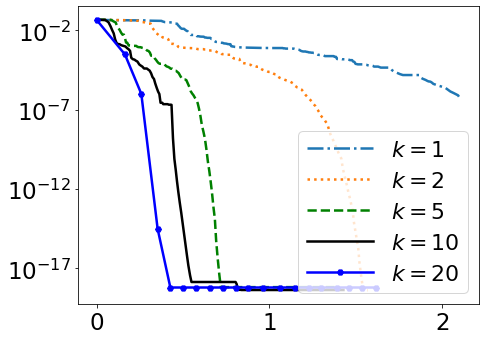

In [ ]:
plt.rcParams['figure.figsize'] = (7, 5) #graph-size
params = {'legend.fontsize': 22,
          'legend.handlelength': 3} #legend-size
plt.rcParams.update(params)
plt.plot(mush_time_grsr_1[:300],mush_res_grsr_1[:300],'-.',linewidth=2.5,label="$k=1$")
plt.plot(mush_time_grsr_2[:200],mush_res_grsr_2[:200],':',linewidth=2.5,label="$k=2$")
plt.plot(mush_time_grsr_5[:200],mush_res_grsr_5[:200],'--g',linewidth=2.5,label="$k=5$")
plt.plot(mush_time_grsr_10[:200],mush_res_grsr_10[:200],'-k',linewidth=2.5, label="$k=10$")
plt.plot(mush_time_grsr_20[:200:10],mush_res_grsr_20[:200:10],'-Hb',linewidth=2.5,label="$k=20$")
plt.tick_params(labelsize=23) #axis-size
plt.legend(loc="lower right") #legend-loc
plt.yscale("log")

plt.yticks([1e-17,1e-12,1e-7,1e-2])
plt.xticks([0,1,2])
plt.tight_layout()
plt.savefig('blockquasiimg/mushgr.time.png')
plt.savefig('blockquasiimg/mushgr.time.pdf',format='pdf')

In [ ]:
mush_res_rasr_1,mush_time_rasr_1=rasrk_sol(x1.copy(),10,2,1,500,True)

0.04689250365697619
0.0019049720262567453
0.0003435644318043506
9.653863709984326e-05
1.854961601780877e-05
2.436048660147623e-06
1.4955409646914233e-06
1.500547935801835e-11
3.9135276587464705e-19
3.8242014313265824e-19
3.8242014313265824e-19


In [ ]:
mush_res_rasr_2,mush_time_rasr_2=rasrk_sol(x1.copy(),100,20,2,500,True)

0.04721918455543577
0.0014686564475498072
0.0001460101729334321
9.866829173187296e-05
5.636211979735742e-05
7.548413111025974e-08
4.562090032066131e-19
4.562090032066131e-19
4.562090032066131e-19
4.562090032066131e-19
4.562090032066131e-19


In [ ]:
mush_res_rasr_5,mush_time_rasr_5=rasrk_sol(x1.copy(),100,20,5,500,True)

0.04721918455543577
9.690446716895289e-05
9.959220681796651e-11
3.7483705941940994e-19
3.7483705941940994e-19
3.7483705941940994e-19
3.7483705941940994e-19
3.7483705941940994e-19
3.7483705941940994e-19
3.7483705941940994e-19
3.7483705941940994e-19


In [ ]:
mush_res_rasr_10,mush_time_rasr_10=rasrk_sol(x1.copy(),100,20,10,500,True)

0.04721918455543577
3.950569193638932e-08
3.907757619427798e-19
3.907757619427798e-19
3.907757619427798e-19
3.907757619427798e-19
3.907757619427798e-19
3.907757619427798e-19
3.907757619427798e-19
3.907757619427798e-19
3.907757619427798e-19


In [ ]:
mush_res_rasr_20,mush_time_rasr_20=rasrk_sol(x1.copy(),100,20,20,500,True)

0.04721918455543577
1.2597452663247615e-18
5.923604246574283e-19
5.923604246574283e-19
5.923604246574283e-19
5.923604246574283e-19
5.923604246574283e-19
5.923604246574283e-19
5.923604246574283e-19
5.923604246574283e-19
5.923604246574283e-19


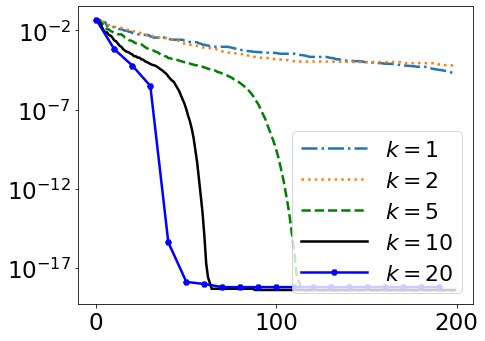

In [ ]:
plt.rcParams['figure.figsize'] = (7, 5) #graph-size
params = {'legend.fontsize': 22,
          'legend.handlelength': 3} #legend-size
plt.rcParams.update(params)
plt.plot(mush_res_rasr_1[:200],'-.',linewidth=2.5,label="$k=1$")
plt.plot(mush_res_rasr_2[:200],':',linewidth=2.5,label="$k=2$")
plt.plot(mush_res_rasr_5[:200],'--g',linewidth=2.5,label="$k=5$")
plt.plot(mush_res_rasr_10[:200],'-k',linewidth=2.5, label="$k=10$")
plt.plot(np.arange(0, 200, 10),mush_res_rasr_20[:200:10],'-Hb',linewidth=2.5,label="$k=20$")
plt.tick_params(labelsize=23) #axis-size
plt.legend(loc="lower right") #legend-loc
plt.yscale("log")

plt.yticks([1e-17,1e-12,1e-7,1e-2])
plt.xticks([0,100,200])
plt.tight_layout()
plt.savefig('blockquasiimg/mushra.res.png')
plt.savefig('blockquasiimg/mushra.res.pdf',format='pdf')

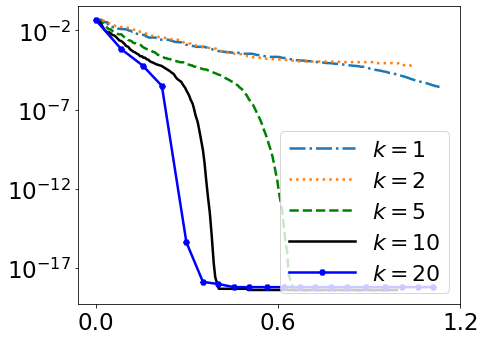

In [ ]:
plt.rcParams['figure.figsize'] = (7, 5) #graph-size
params = {'legend.fontsize': 22,
          'legend.handlelength': 3} #legend-size
plt.rcParams.update(params)
plt.plot(mush_time_rasr_1[:230],mush_res_rasr_1[:230],'-.',linewidth=2.5,label="$k=1$")
plt.plot(mush_time_rasr_2[:200],mush_res_rasr_2[:200],':',linewidth=2.5,label="$k=2$")
plt.plot(mush_time_rasr_5[:200],mush_res_rasr_5[:200],'--g',linewidth=2.5,label="$k=5$")
plt.plot(mush_time_rasr_10[:200],mush_res_rasr_10[:200],'-k',linewidth=2.5, label="$k=10$")
plt.plot(mush_time_rasr_20[:200:10],mush_res_rasr_20[:200:10],'-Hb',linewidth=2.5,label="$k=20$")
plt.tick_params(labelsize=23) #axis-size
plt.legend(loc="lower right") #legend-loc
plt.yscale("log")

plt.yticks([1e-17,1e-12,1e-7,1e-2])
plt.xticks([0,0.6,1.2])
plt.tight_layout()
plt.savefig('blockquasiimg/mushra.time.png')
plt.savefig('blockquasiimg/mushra.time.pdf',format='pdf')